In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
keras = tf.keras
from scipy import stats
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

In [381]:
X_train = pd.read_csv('../data/train_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../data/test_clean.csv', index_col='Date').drop(columns='Unnamed: 0')

In [382]:
X_train

Temperature  Fuel_Price       CPI  Unemployment  \
Date                                                                   
2010-02-05 00:00:00    -0.956241   -1.694130  1.003435      0.167116   
2010-02-12 00:00:00    -1.160856   -1.746757  1.007199      0.167116   
2010-02-19 00:00:00    -1.084394   -1.821313  1.008412      0.167116   
2010-02-26 00:00:00    -0.723626   -1.718251  1.009200      0.167116   
2010-03-05 00:00:00    -0.730626   -1.577911  1.009987      0.167116   
...                          ...         ...       ...           ...   
2012-09-28 00:00:00     0.259065    1.430624  0.510776      0.524164   
2012-10-05 00:00:00     0.259604    1.404310  0.514826      0.513663   
2012-10-12 00:00:00    -0.301472    1.437202  0.518875      0.513663   
2012-10-19 00:00:00    -0.193780    1.369225  0.518968      0.513663   
2012-10-26 00:00:00    -0.065626    1.178451  0.518401      0.513663   

                         Size  Type_x0_A  Type_x0_B  Type_x0_C  Month_x0_1  \
Date                                                                         
2010-02-05 00:00:00  0.347697        1.0        0.0        0.0         0.0   
2010-02-12 00:00:00  0.347697        1.0        0.0        0.0         0.0   
2010-02-19 00:00:00  0.347697        1.0        0.0        0.0         0.0   
2010-02-26 00:00:00  0.347697        1.0        0.0        0.0         0.0   
2010-03-05 00:00:00  0.347697        1.0        0.0        0.0         0.0   
...                       ...        ...        ...        ...         ...   
2012-09-28 00:00:00 -0.200984        0.0        1.0        0.0         0.0   
2012-10-05 00:00:00 -0.200984        0.0        1.0        0.0         0.0   
2012-10-12 00:00:00 -0.200984        0.0        1.0        0.0         0.0   
2012-10-19 00:00:00 -0.200984        0.0        1.0        0.0         0.0   
2012-10-26 00:00:00 -0.200984        0.0        1.0        0.0         0.0   

                     Month_x0_2  Month_x0_3  Month_x0_4  Month_x0_5  \
Date                                                                  
2010-02-05 00:00:00         1.0         0.0         0.0         0.0   
2010-02-12 00:00:00         1.0         0.0         0.0         0.0   
2010-02-19 00:00:00         1.0         0.0         0.0         0.0   
2010-02-26 00:00:00         1.0         0.0         0.0         0.0   
2010-03-05 00:00:00         0.0         1.0         0.0         0.0   
...                         ...         ...         ...         ...   
2012-09-28 00:00:00         0.0         0.0         0.0         0.0   
2012-10-05 00:00:00         0.0         0.0         0.0         0.0   
2012-10-12 00:00:00         0.0         0.0         0.0         0.0   
2012-10-19 00:00:00         0.0         0.0         0.0         0.0   
2012-10-26 00:00:00         0.0         0.0         0.0         0.0   

                     Month_x0_6  Month_x0_7  Month_x0_8  Month_x0_9  \
Date                                                                  
2010-02-05 00:00:00         0.0         0.0         0.0         0.0   
2010-02-12 00:00:00         0.0         0.0         0.0         0.0   
2010-02-19 00:00:00         0.0         0.0         0.0         0.0   
2010-02-26 00:00:00         0.0         0.0         0.0         0.0   
2010-03-05 00:00:00         0.0         0.0         0.0         0.0   
...                         ...         ...         ...         ...   
2012-09-28 00:00:00         0.0         0.0         0.0         1.0   
2012-10-05 00:00:00         0.0         0.0         0.0         0.0   
2012-10-12 00:00:00         0.0         0.0         0.0         0.0   
2012-10-19 00:00:00         0.0         0.0         0.0         0.0   
2012-10-26 00:00:00         0.0         0.0         0.0         0.0   

                     Month_x0_10  Month_x0_11  Month_x0_12  Store  IsHoliday  \
Date                                                                           
2010-02-05 00:00:00          0.0          0.0          0.0   

In [383]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)

In [384]:
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [385]:
def windowize_data(data, n_prev, n_future, create_y=False):
    '''
    returns:
        x: np array with shape (n_predictions, n_prev, 1)
        y: np array with shape (n_predictions, n_future, 1)
    '''
    n_predictions = len(data) - n_prev - n_future +1
    
    x_indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[x_indices, None]

    if create_y:
        y = data[n_prev:]
        dates = data.index[n_prev:]
        y_indices = np.arange(n_future) + np.arange(n_predictions)[:, None]
        y = y[y_indices, None]
        y_dates = dates[y_indices, None]

        return x, y, y_dates
    else:
        return x

def window_multi_groups(data, n_prev, n_future, create_y=False):
    '''
    returns:
        x: np array with shape (n_predictions * number of stores, n_prev, 1)
        y: np array with shape (n_predictions * number of stores, n_future, 1)
    '''
    ncols = data.shape[1]
    n_pred = len(data) - n_prev - n_future +1
    n_total_pred = n_pred * ncols
    x = np.zeros((n_total_pred, n_prev, 1))
    if create_y:
        y = np.zeros((n_total_pred, n_future, 1))
        y_dates = np.empty((n_total_pred, n_future, 1),dtype='datetime64[ns]')
        for i in range(ncols):
            start = i * n_pred
            stop = start + n_pred
            x[start:stop, :, :], y[start:stop, :, :], y_dates[start:stop, :, :] = windowize_data(data.iloc[:,i], n_prev, n_future, create_y=create_y)
        return x, y, y_dates
    else:
        for i in range(ncols):
            start = i * n_pred
            stop = start + n_pred
            x[start:stop, :, :]= windowize_data(data.iloc[:,i], n_prev, n_future, create_y=create_y)
        return x

def window_multivar(data, n_prev, n_future, feats=None, target='Weekly_Sales'):
    '''
    returns:
        x: np array with shape (n_predictions * number of stores, n_prev, n_feats)
        y: np array with shape (n_predictions * number of stores, n_future, 1)
        y_dates: np array with shape (n_predictions * number of stores, n_future, 1)
    '''
    piv = data[['Store', target]].pivot_table(target, data.index, 'Store')
    X, y, y_dates = window_multi_groups(piv, n_prev, n_future, create_y=True)
    if feats != None:
        for feat in feats:
            piv = data[['Store', feat]].pivot_table(feat, data.index, 'Store')
            X_feat = window_multi_groups(piv, n_prev, n_future)
            X = np.dstack((X, X_feat))
    return X, y, y_dates

In [386]:
n_prev = 54
n_future = 10
# 6 into future

feats = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'Month_x0_11', 'Month_x0_12', 'IsHoliday']
# feats = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
n_feats = len(feats)

X_train_window, y_train_window, y_train_dates = window_multivar(X_train, n_prev, n_future, feats)
X_test_window, y_test_window, y_test_dates = window_multivar(X_test, n_prev, n_future, feats)

# X_train_window, y_train_window, y_train_dates = windowize_data(piv_train.iloc[:,2], n_prev, n_future)
# X_test_window, y_test_window, y_test_dates = windowize_data(piv_test, n_prev, n_future)
n_feats

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: Support for multi-d

8

In [345]:
X_test_window.shape, y_train_window.shape

((2880, 54, 9), (2880, 10, 1))

In [354]:
model = keras.Sequential(name='Encoder-Decoder-LSTM_multivar')
model.add(keras.layers.LSTM(64, input_shape=(n_prev, n_feats+1), return_sequences=False, activation='relu')) # 1 is num of variables to predict on
model.add(keras.layers.RepeatVector(n_future))
model.add(keras.layers.LSTM(64, return_sequences=True, activation='relu'))
# model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1, activation='linear')))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [288]:

model = keras.Sequential(name='Stacked-LSTM')
model.add(keras.layers.LSTM(64, input_shape=(n_prev, 1), return_sequences=True)) # 1 is num of variables to predict on
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(n_future, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [346]:
model = keras.Sequential(name='SimpleCNN_multivar')
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_prev, n_feats+1)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(n_future, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')

In [322]:
model = keras.Sequential(name='WaveNet_one_round')
model.add(keras.layers.InputLayer(input_shape=(n_prev, n_feats+1)))
for rate in (1, 2, 4, 8, 16, 32): 
    model.add(keras.layers.Conv1D(filters=50, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate)) 
model.add(keras.layers.Conv1D(filters=50, kernel_size=1)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_future, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mape')

In [323]:
#large n_prev, more dilation (1,2,4,8,16,32), roll up to Store level

In [355]:
model.summary()

Model: "Encoder-Decoder-LSTM_multivar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18944     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             65        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [325]:
X_train_window.shape, y_train_window.shape

((2880, 54, 9), (2880, 10, 1))

In [356]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
filepath = f'../models/{model.name}.h5'
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=20,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint(filepath, save_best_only=True)
]


history = model.fit(X_train_window, y_train_window, epochs=1000, batch_size=32, validation_split=0.2, callbacks=callbacks) 



Epoch 1/1000
72/72 [==============================] - 2s 31ms/step - loss: 61.8070 - val_loss: 47.7704
Epoch 2/1000
72/72 [==============================] - 2s 28ms/step - loss: 43.7765 - val_loss: 44.4053
Epoch 3/1000
72/72 [==============================] - 2s 28ms/step - loss: 39.7257 - val_loss: 31.5628
Epoch 4/1000
72/72 [==============================] - 2s 27ms/step - loss: 41.8319 - val_loss: 35.0707
Epoch 5/1000
72/72 [==============================] - 2s 27ms/step - loss: 50.1211 - val_loss: 91.8202
Epoch 6/1000
72/72 [==============================] - 2s 27ms/step - loss: 106.7019 - val_loss: 63.6294
Epoch 7/1000
72/72 [==============================] - 2s 27ms/step - loss: 91.9890 - val_loss: 84.4494
Epoch 8/1000
72/72 [==============================] - 2s 27ms/step - loss: 65.6867 - val_loss: 45.1165
Epoch 9/1000
72/72 [==============================] - 2s 27ms/step - loss: 83.9363 - val_loss: 53.3777
Epoch 10/1000
72/72 [==============================] - 2s 27ms/step - lo

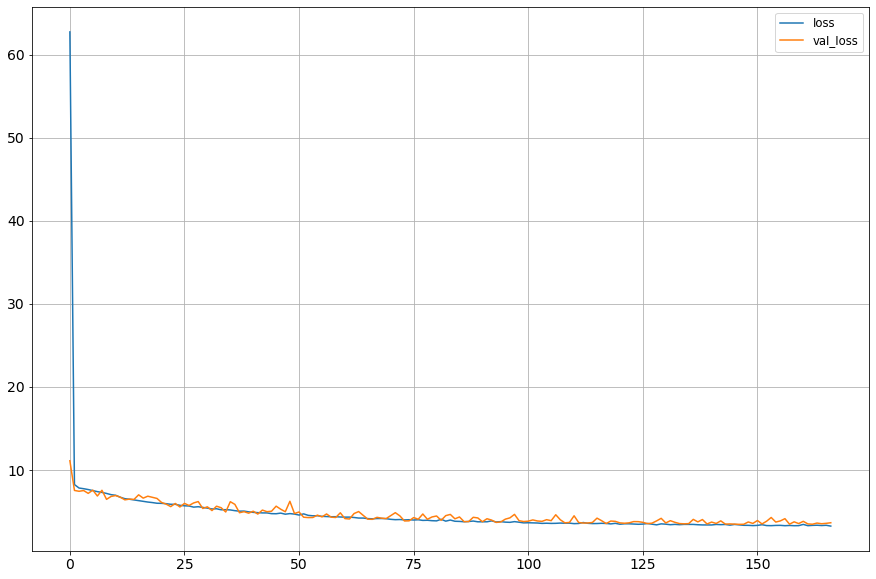

In [327]:
pd.DataFrame(history.history).plot(figsize= (15, 10)) 
plt.grid(True) 
 # set the vertical range to [0-1]



In [387]:
model = keras.models.load_model("../models/WaveNet_additional_feats.h5")


In [388]:
y_pred = model.predict(X_test_window)

In [389]:
model_loss = model.evaluate(X_test_window, y_test_window, batch_size=32)
model_loss

23/23 [==============================] - 0s 3ms/step - loss: 3.9746


3.974647045135498

In [390]:
np.mean(keras.metrics.MAPE(y_test_window.reshape(-1,10),y_pred))

3.974647

In [131]:
X_test_window.shape

(720, 54, 1)

In [60]:
y_pred[:10]

array([[399733.94, 389930.78, 387920.7 , 379564.12, 377465.56, 372264.03,
        376124.25, 384357.06, 371308.12, 370025.94],
       [394563.72, 390883.  , 385794.16, 379971.25, 378693.22, 374221.5 ,
        376068.47, 381360.44, 369463.34, 368134.56],
       [394067.84, 387253.7 , 388069.72, 381496.25, 384657.62, 376182.6 ,
        373431.28, 380216.06, 369580.97, 371680.16],
       [389905.97, 388827.3 , 386774.38, 386366.25, 385593.6 , 374930.6 ,
        370077.9 , 376666.9 , 373360.3 , 373334.56],
       [391113.8 , 388354.1 , 390560.06, 385226.66, 382993.03, 372842.34,
        372815.94, 380460.38, 374302.53, 379214.75],
       [393107.84, 396325.97, 393780.03, 383719.7 , 380416.25, 372158.4 ,
        376437.22, 378752.5 , 379772.6 , 386796.9 ],
       [396491.88, 392924.34, 387718.06, 379031.78, 378314.38, 375429.9 ,
        376326.5 , 384332.5 , 384369.97, 390642.06],
       [394323.34, 384908.66, 385633.4 , 376399.3 , 382885.38, 374015.16,
        377483.5 , 390350.53, 391878.

In [88]:
y_test_dates[-1], y_test_dates[79+80*2]

(array([['2012-08-24T00:00:00.000000000'],
        ['2012-08-31T00:00:00.000000000'],
        ['2012-09-07T00:00:00.000000000'],
        ['2012-09-14T00:00:00.000000000'],
        ['2012-09-21T00:00:00.000000000'],
        ['2012-09-28T00:00:00.000000000'],
        ['2012-10-05T00:00:00.000000000'],
        ['2012-10-12T00:00:00.000000000'],
        ['2012-10-19T00:00:00.000000000'],
        ['2012-10-26T00:00:00.000000000']], dtype='datetime64[ns]'),
 array([['2012-08-24T00:00:00.000000000'],
        ['2012-08-31T00:00:00.000000000'],
        ['2012-09-07T00:00:00.000000000'],
        ['2012-09-14T00:00:00.000000000'],
        ['2012-09-21T00:00:00.000000000'],
        ['2012-09-28T00:00:00.000000000'],
        ['2012-10-05T00:00:00.000000000'],
        ['2012-10-12T00:00:00.000000000'],
        ['2012-10-19T00:00:00.000000000'],
        ['2012-10-26T00:00:00.000000000']], dtype='datetime64[ns]'))

In [106]:
np.sum(y_pred[0::80], axis=0)

array([8356300.5, 8112218.5, 8136195. , 8010957.5, 8069879. , 8003122.5,
       8061131.5, 8307565. , 8115702.5, 8111578.5], dtype=float32)

In [119]:
len(piv_test) - n_prev - n_future +1

38

In [ ]:
# Holt winters

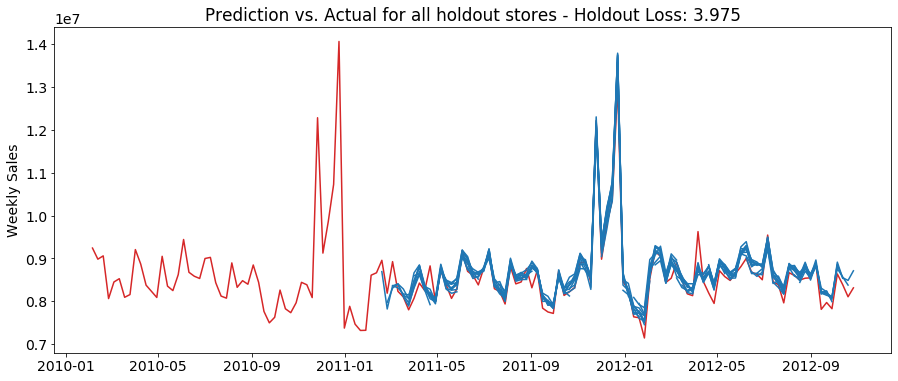

In [391]:
fig, ax = plt.subplots(figsize=(15,6))
piv_test = X_test[['Store', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_test.index,'Store')
ax.plot(piv_test.sum(axis=1), label='actual', color='tab:red')
n_pred = len(piv_test) - n_prev - n_future +1
for i in range(0,n_pred):
    ax.plot(y_test_dates.reshape(-1,n_future)[i], np.sum(y_pred[i::n_pred], axis=0), label=f'prediction {i}', color='tab:blue')
# for i in range(6):
#     ax.plot(y_train_dates.reshape(-1,10)[i], y_pred[i], label=f'prediction {i}', color='tab:blue')
#     print(y_pred[0][i])
# ax.plot(piv_train.iloc[:,2], label='actual', color='tab:blue')


# ax.plot(y_test_dates.reshape(-1,10)[79], y_test_window.reshape(-1,10)[79::80].sum(axis=0), label='actual')
# ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
# ax.legend()
ax.set_title(f'Prediction vs. Actual for all holdout stores - Holdout Loss: {model_loss:.3f}')
ax.set_ylabel('Weekly Sales');

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures creat

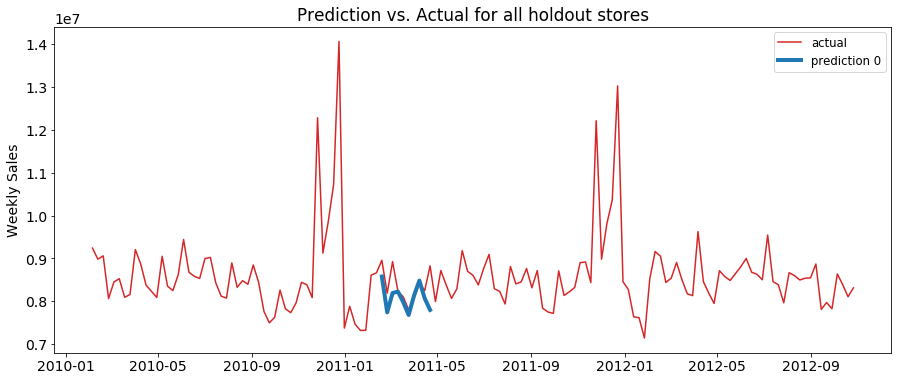

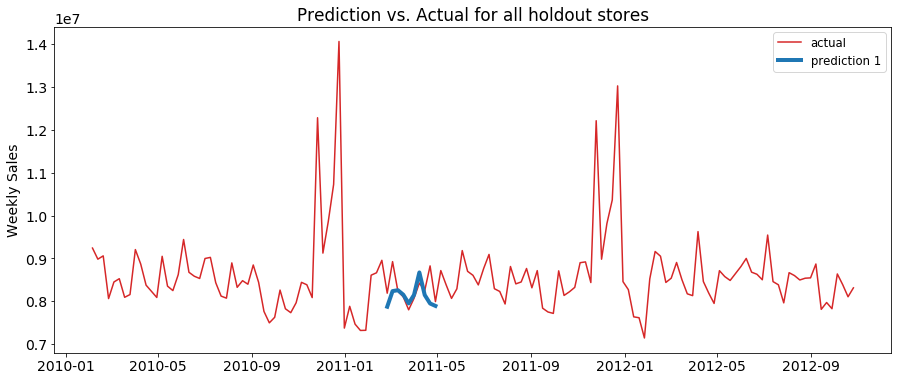

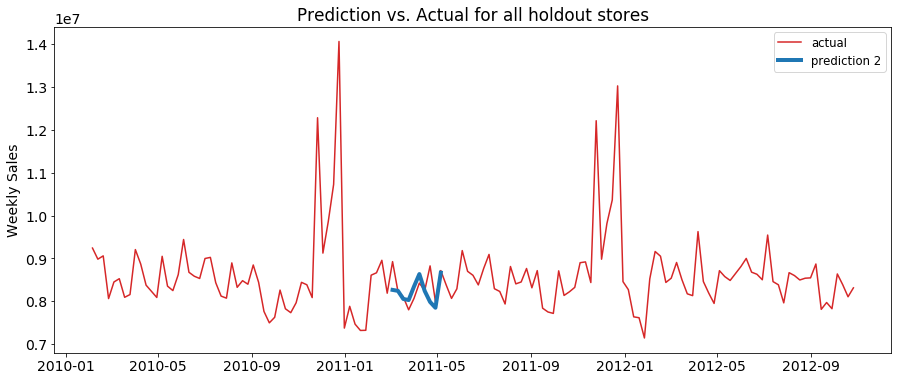

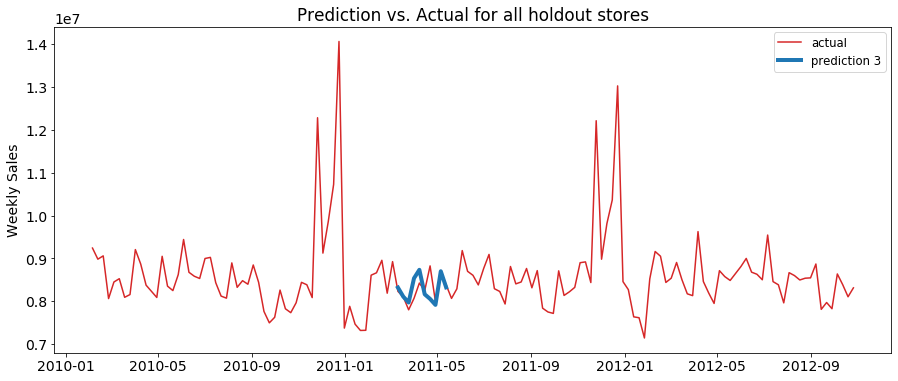

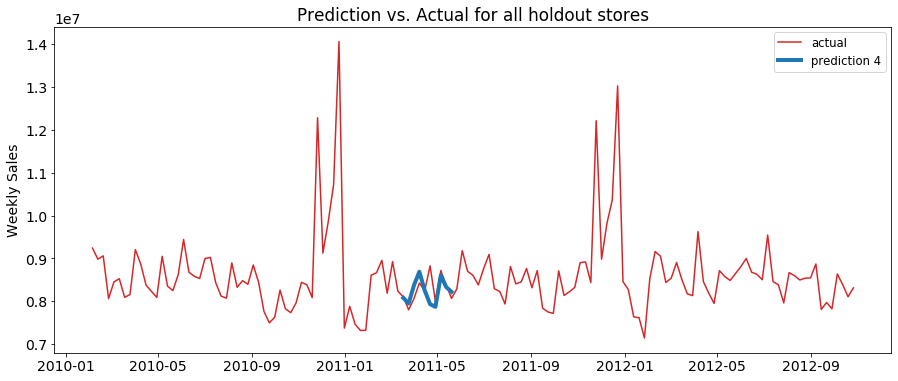

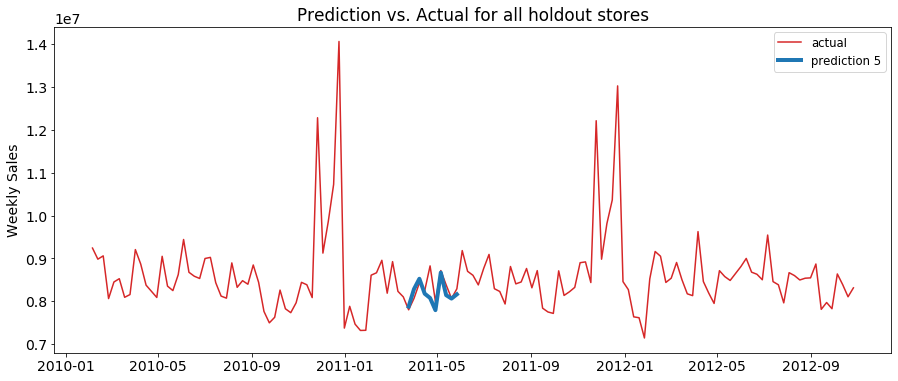

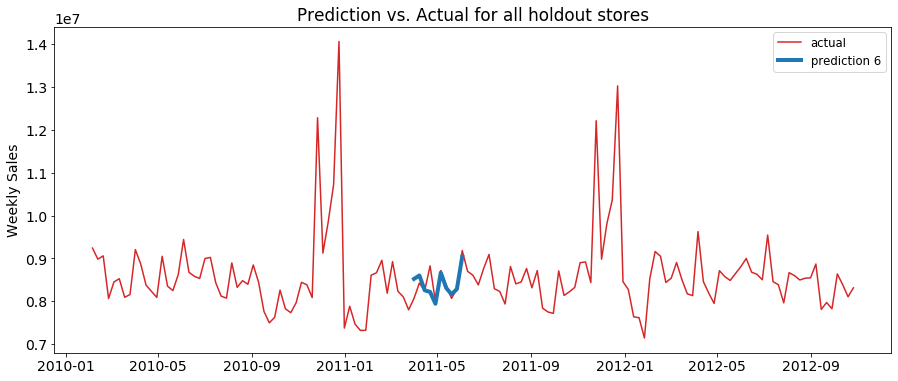

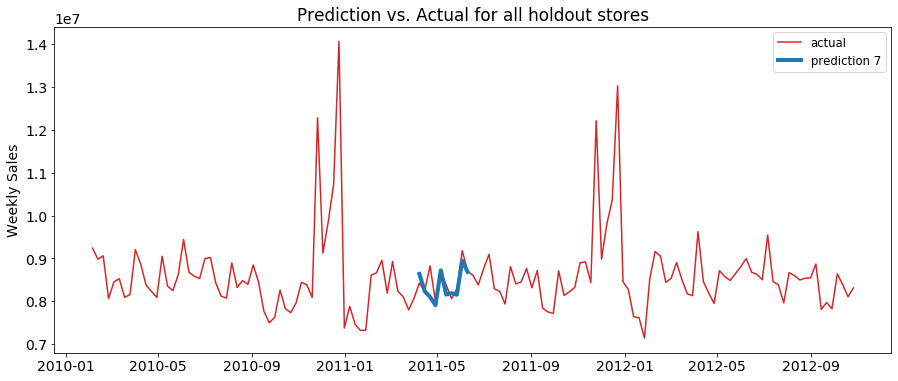

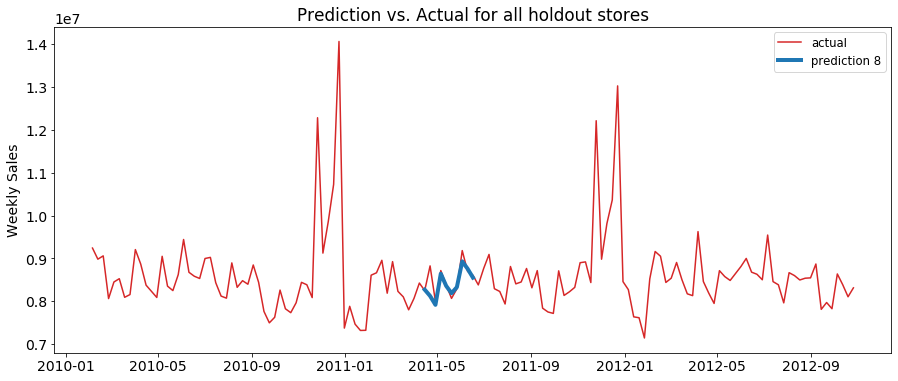

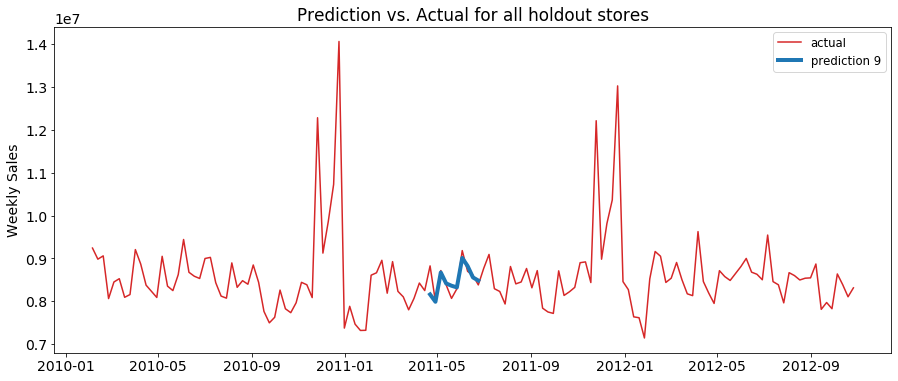

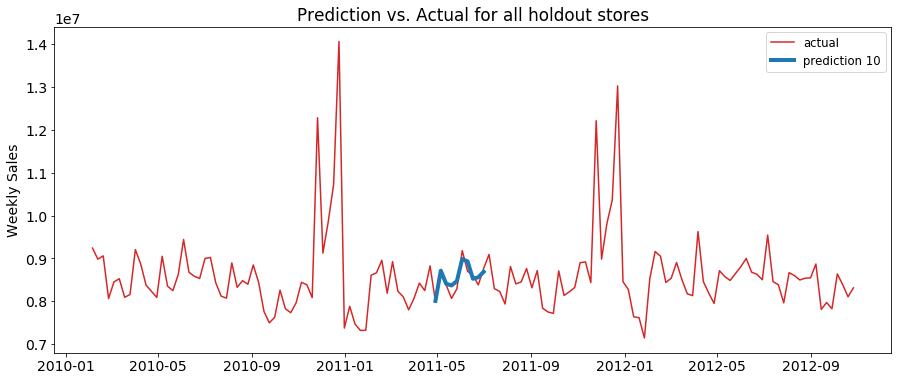

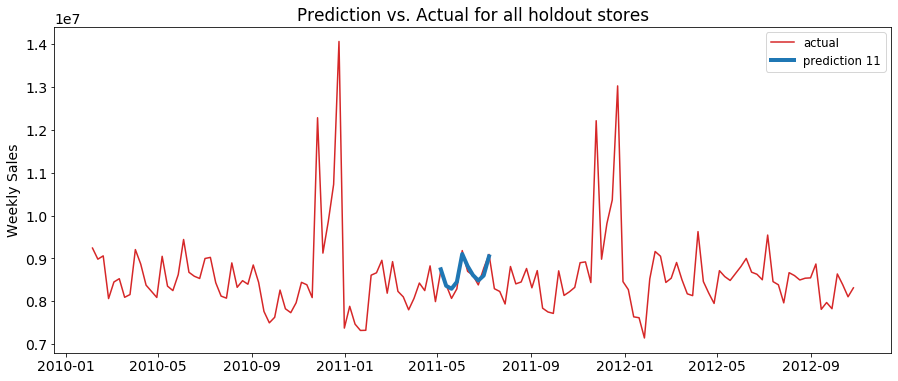

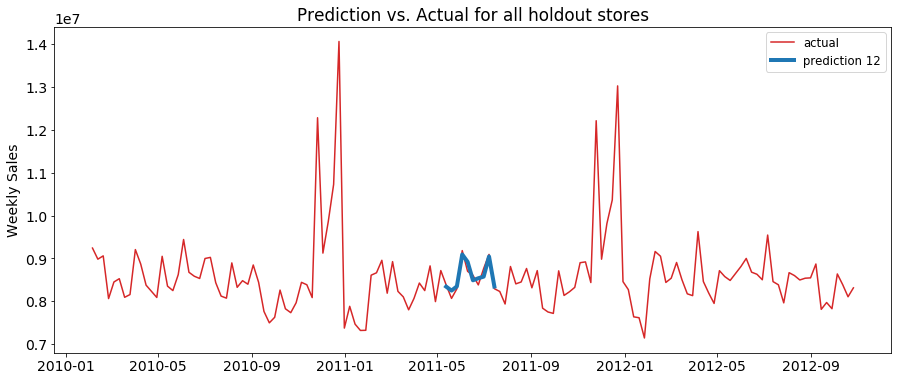

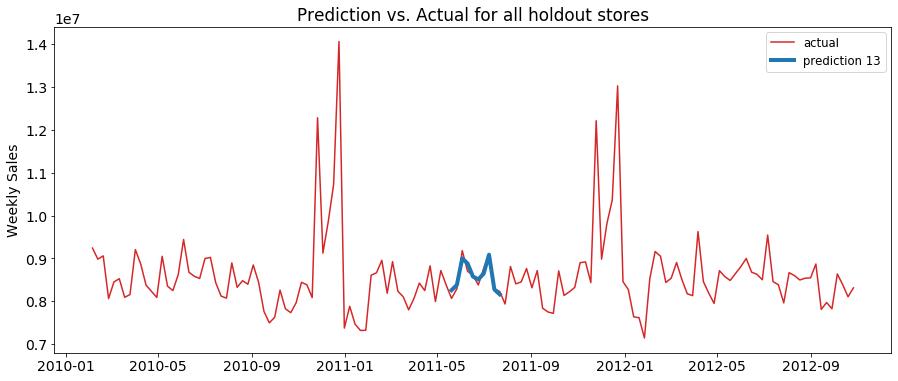

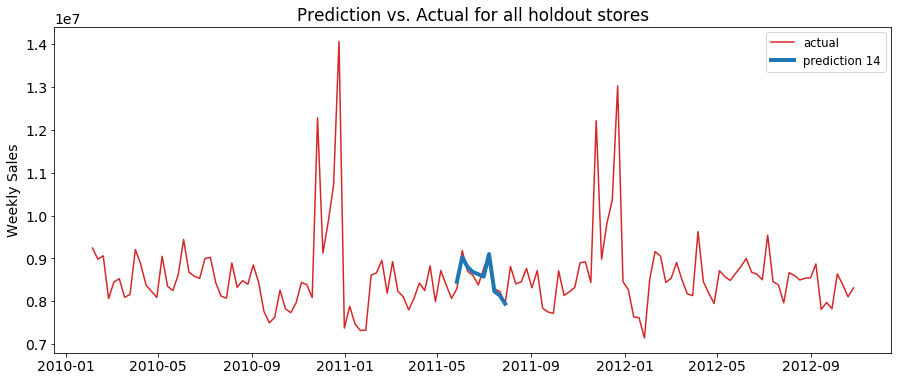

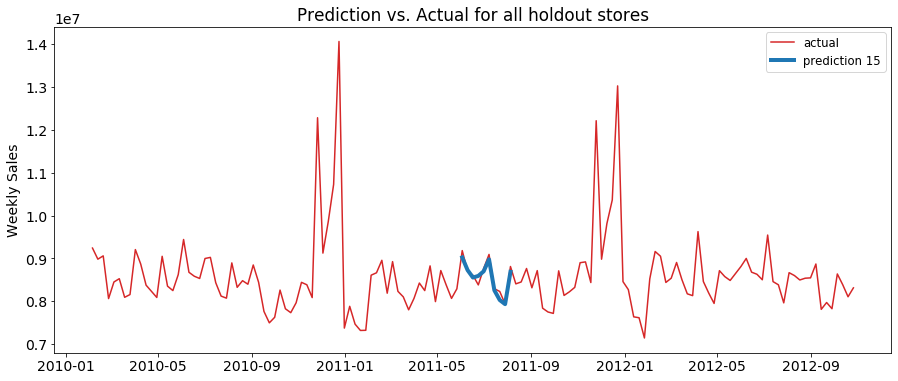

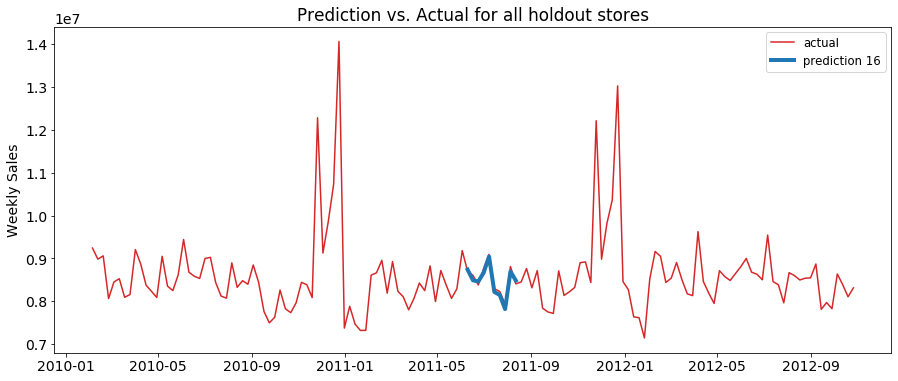

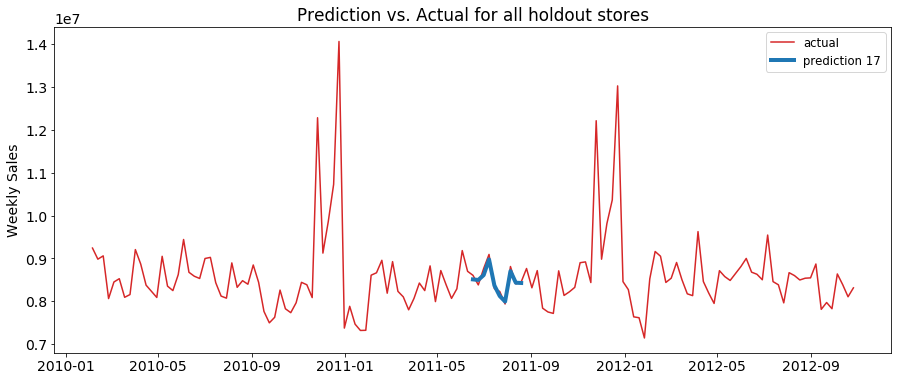

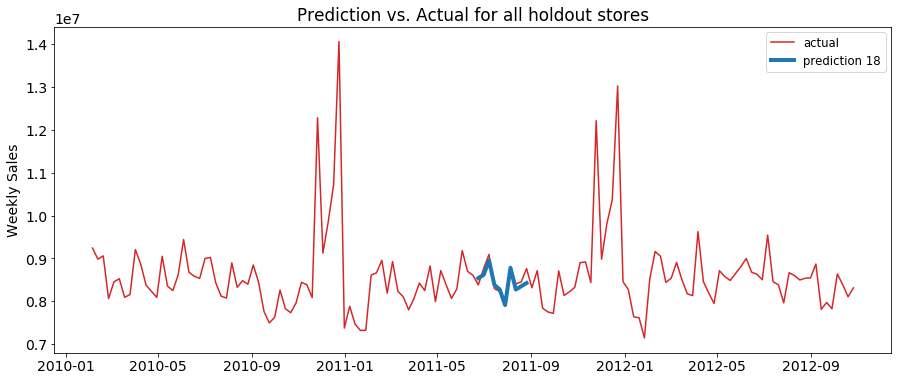

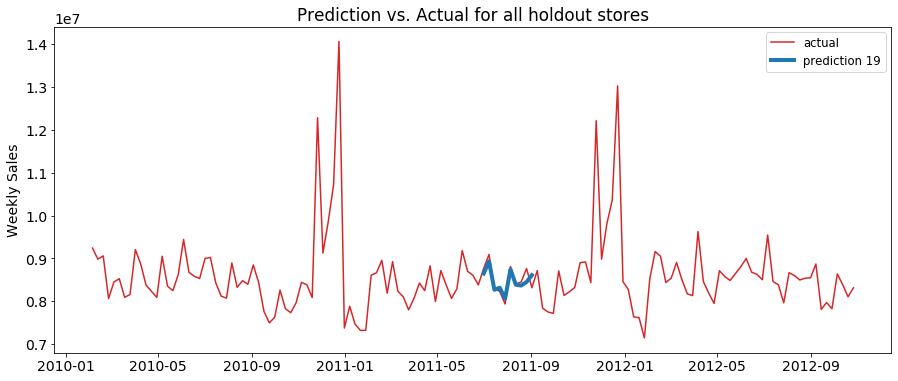

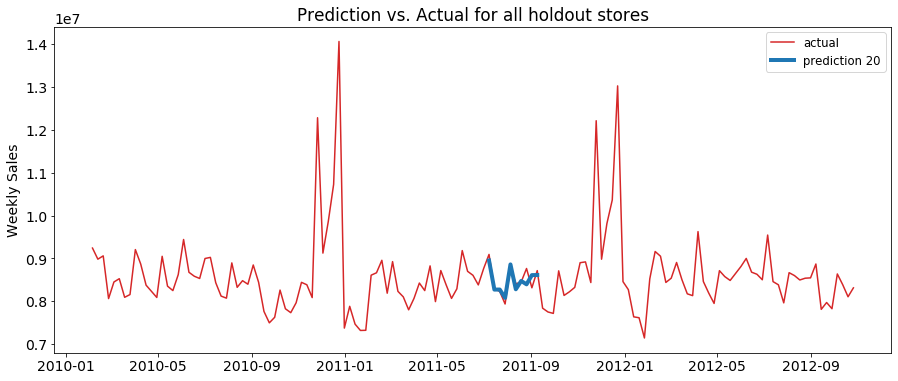

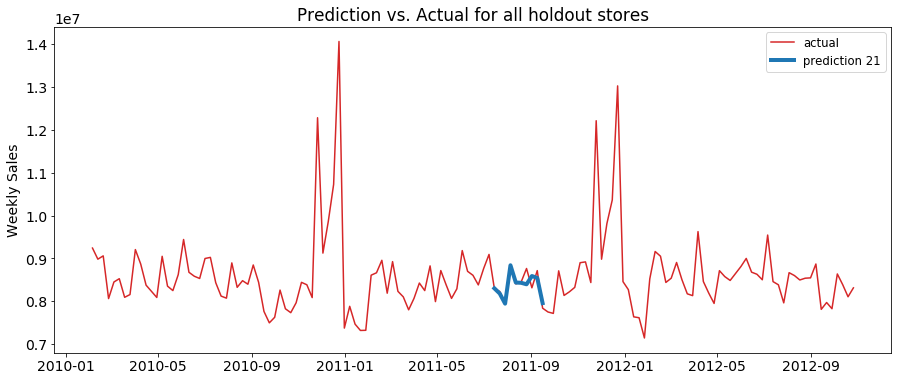

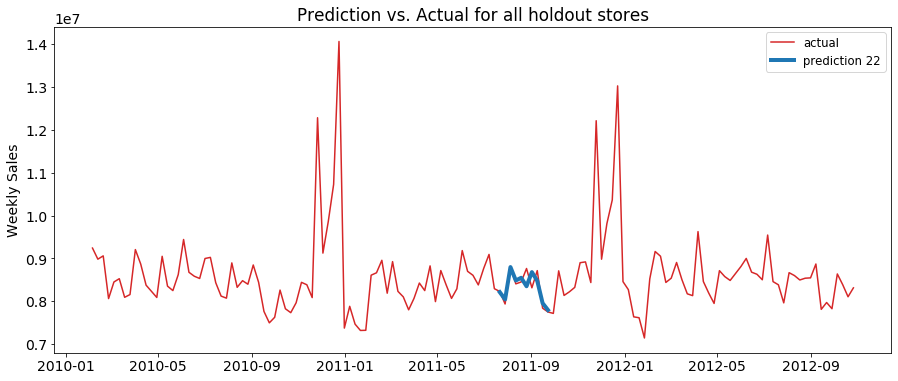

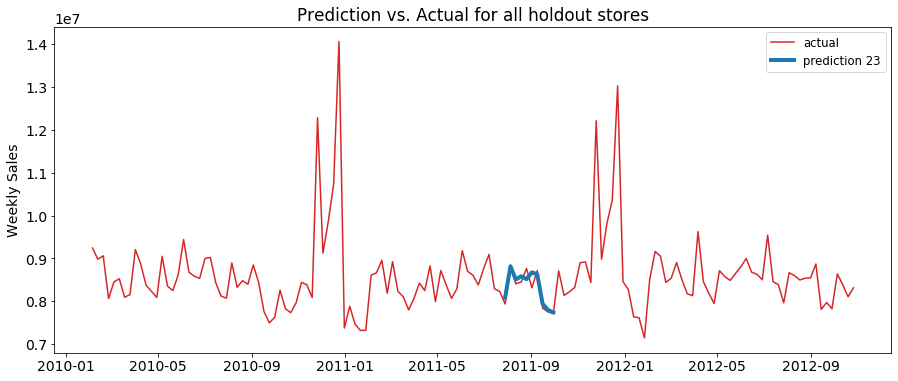

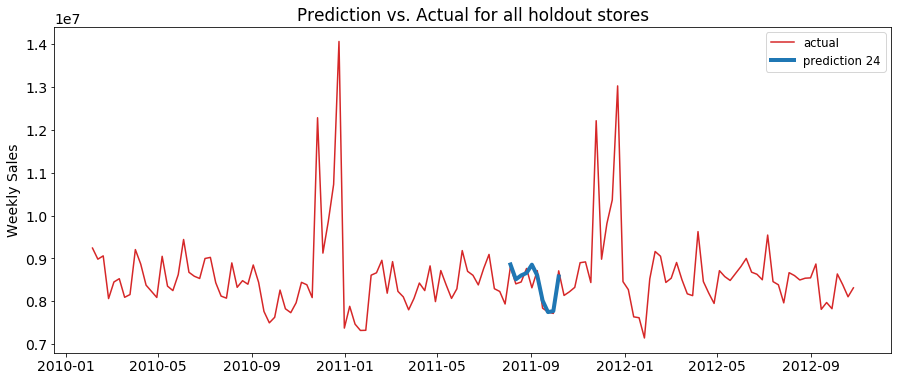

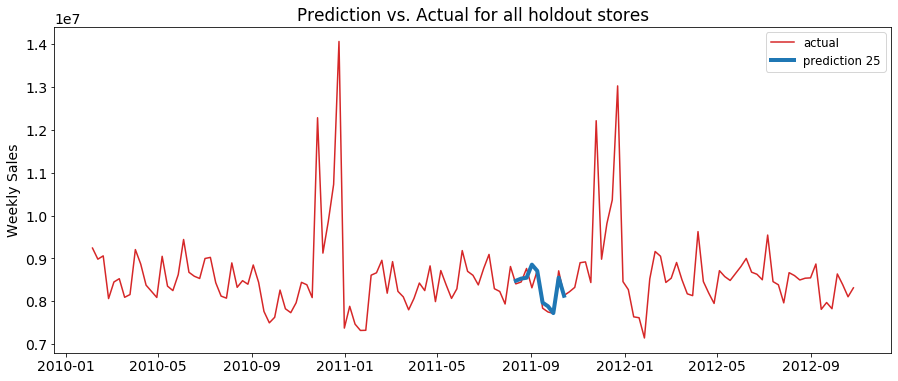

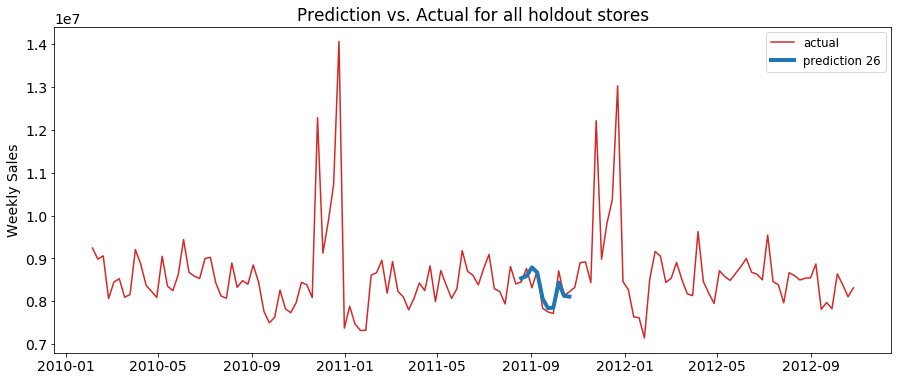

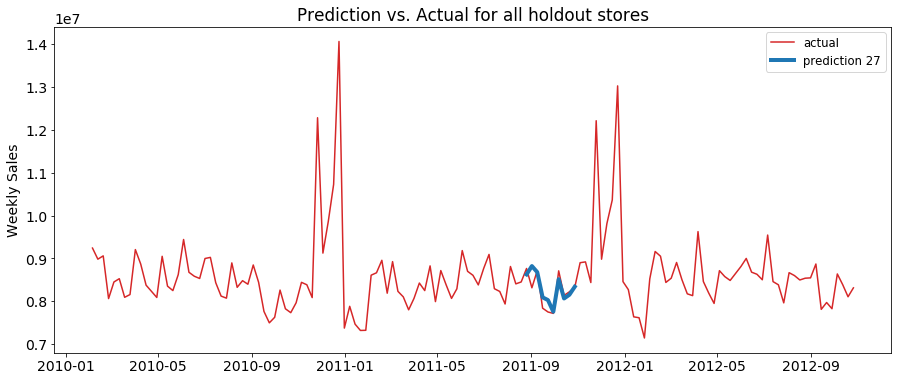

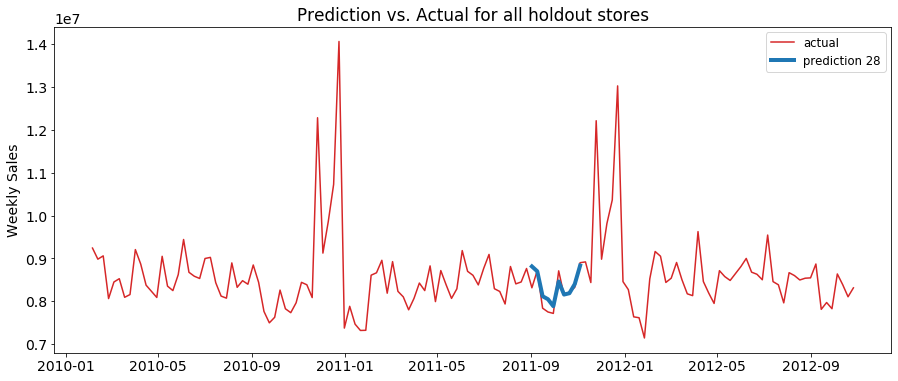

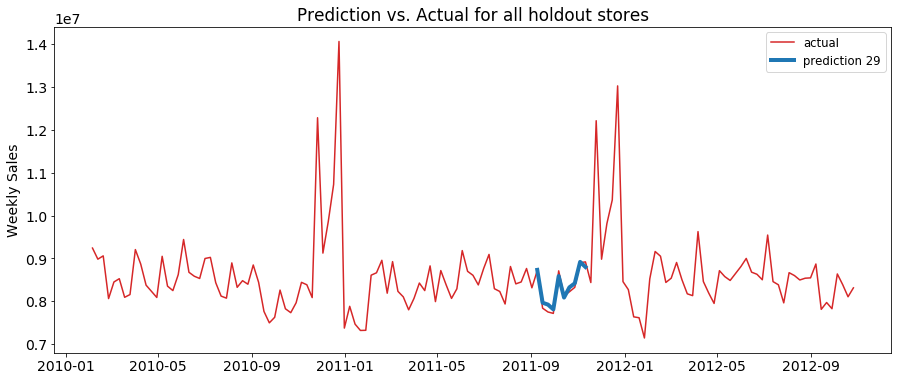

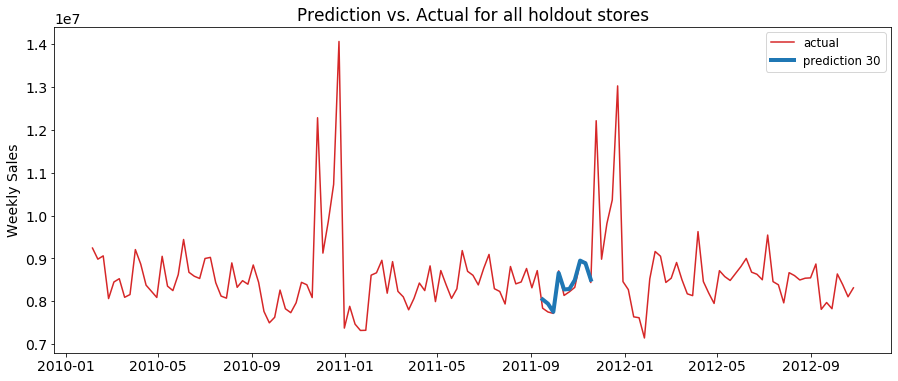

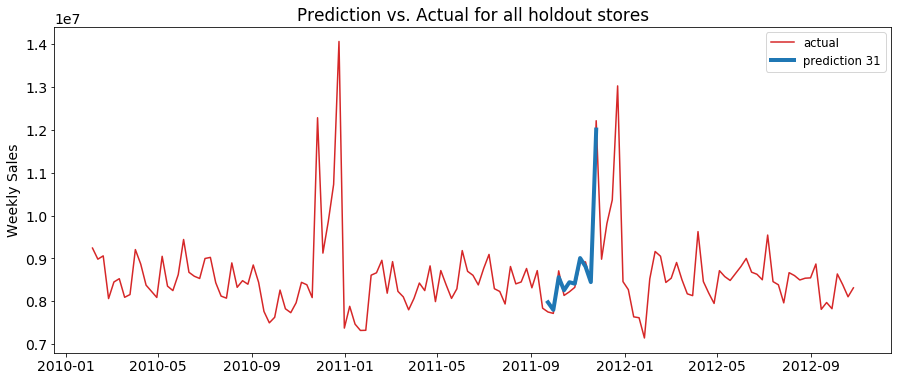

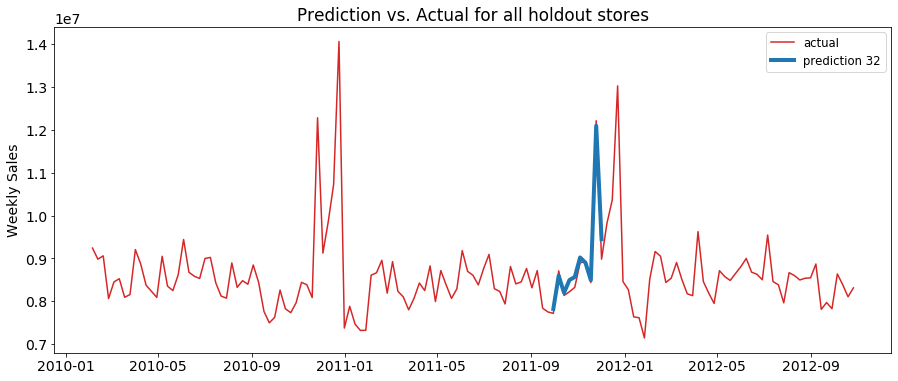

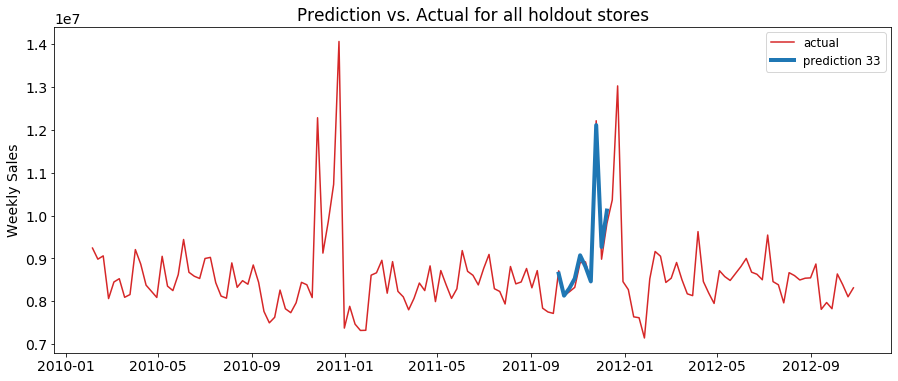

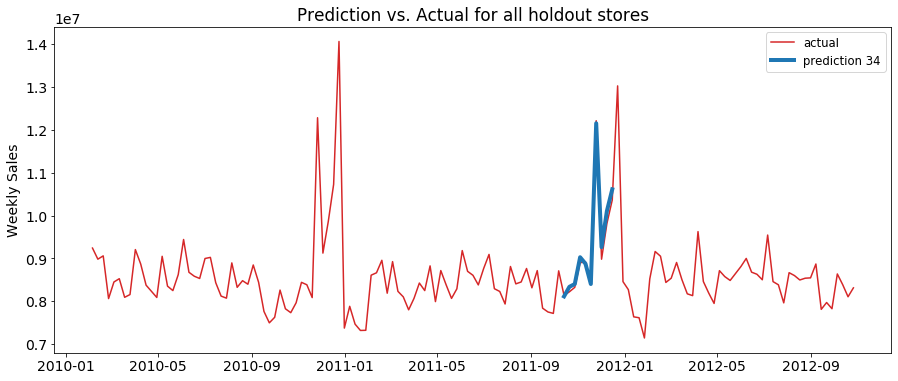

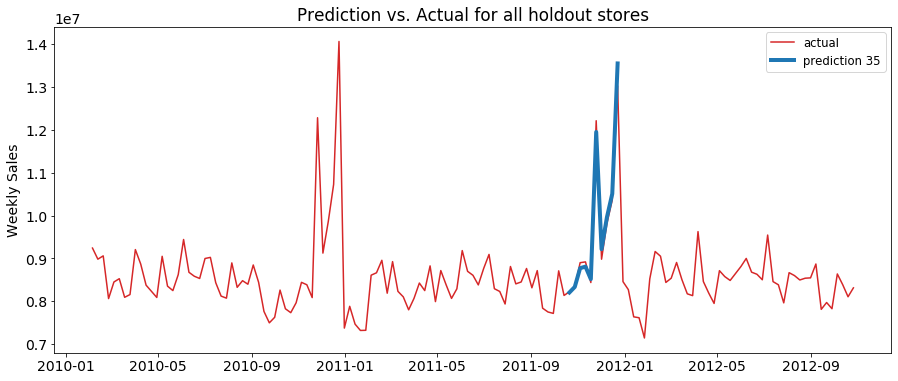

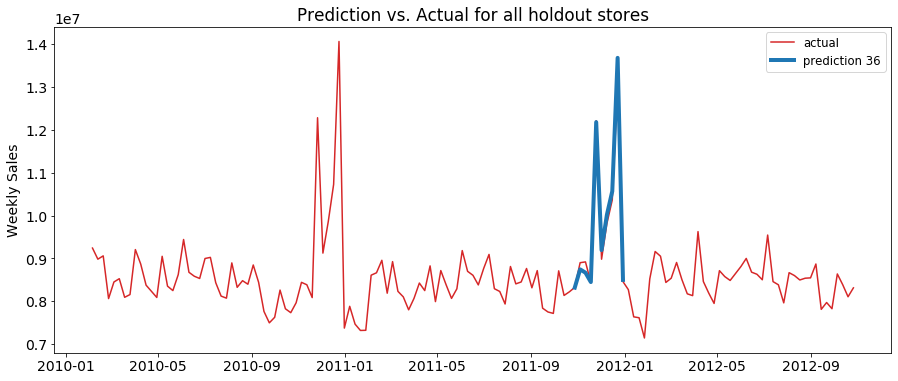

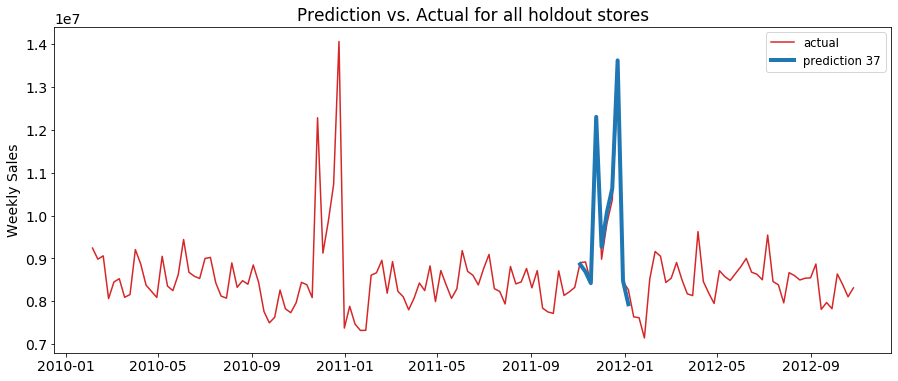

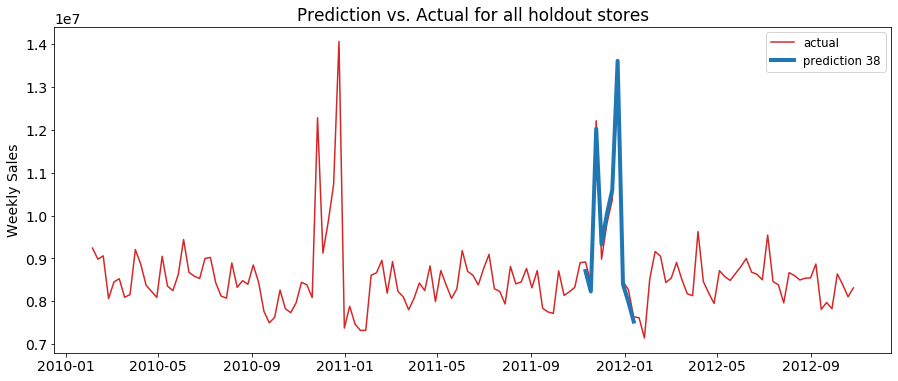

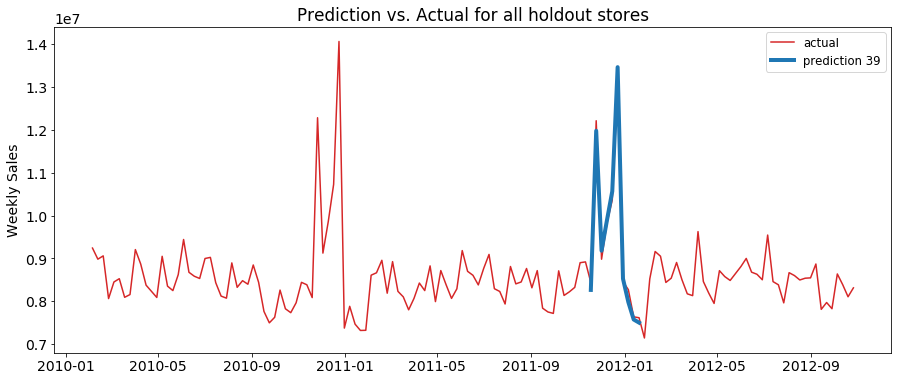

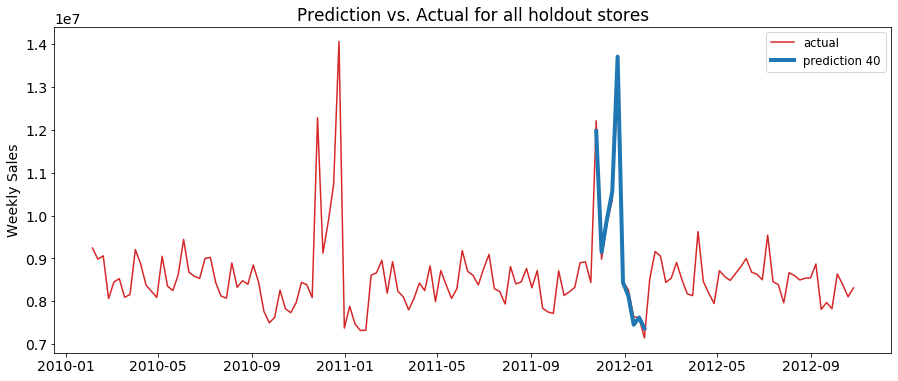

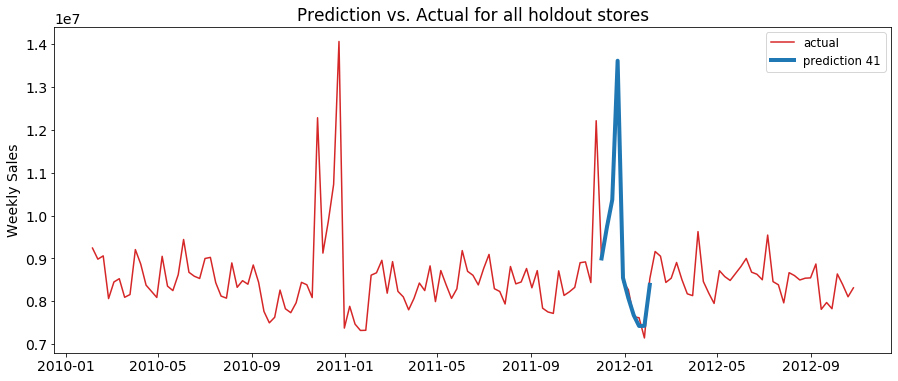

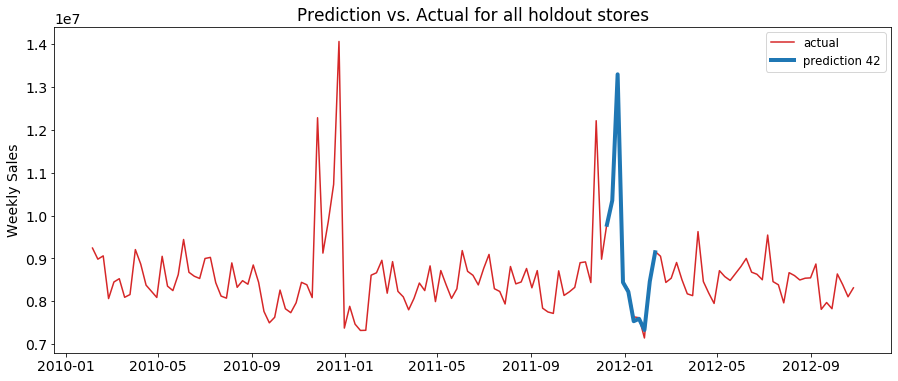

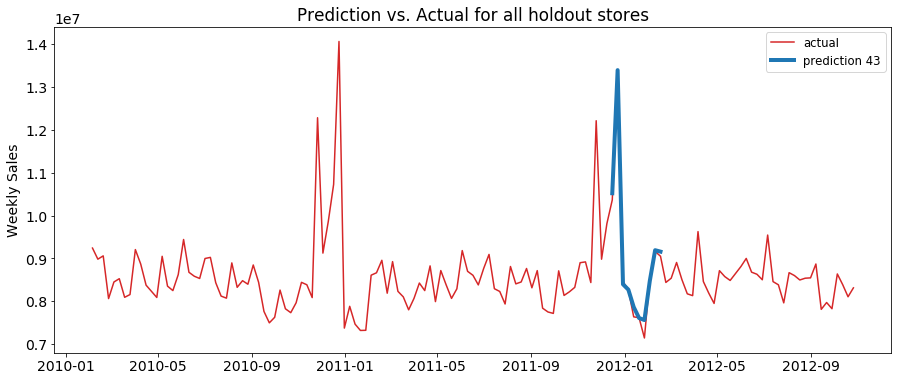

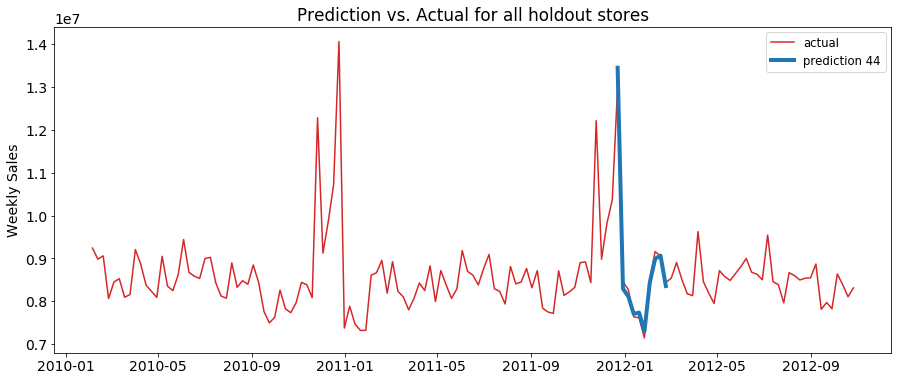

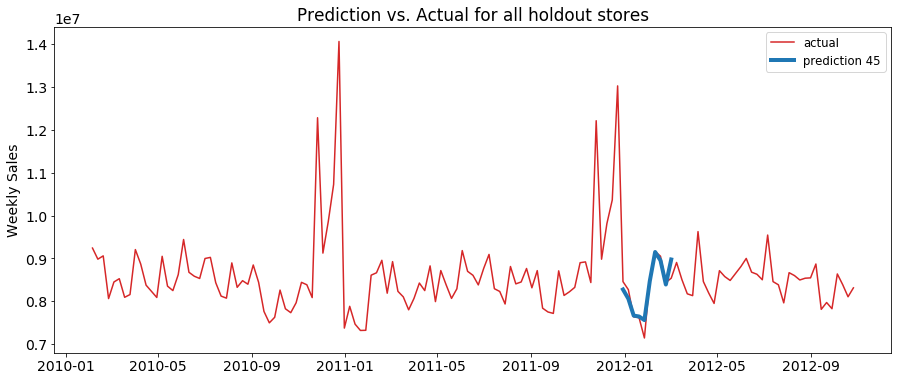

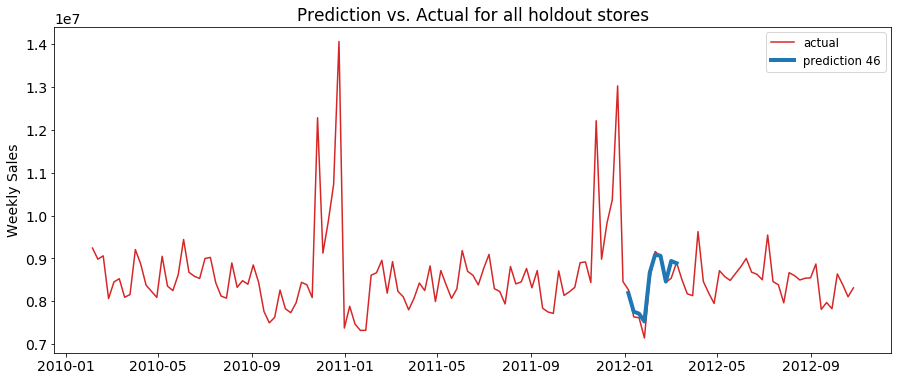

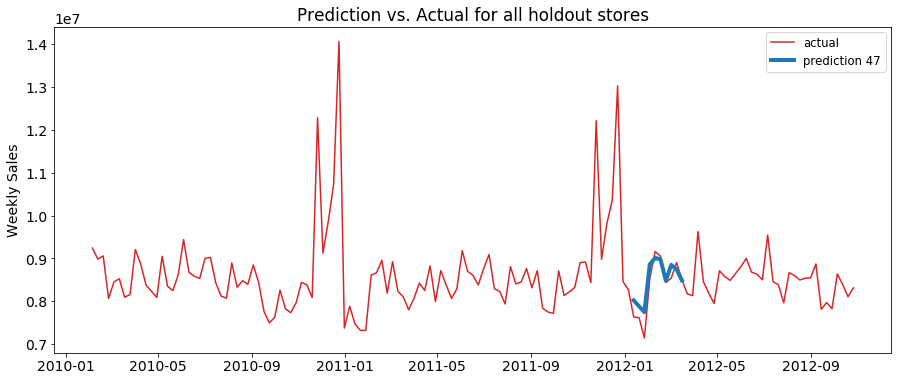

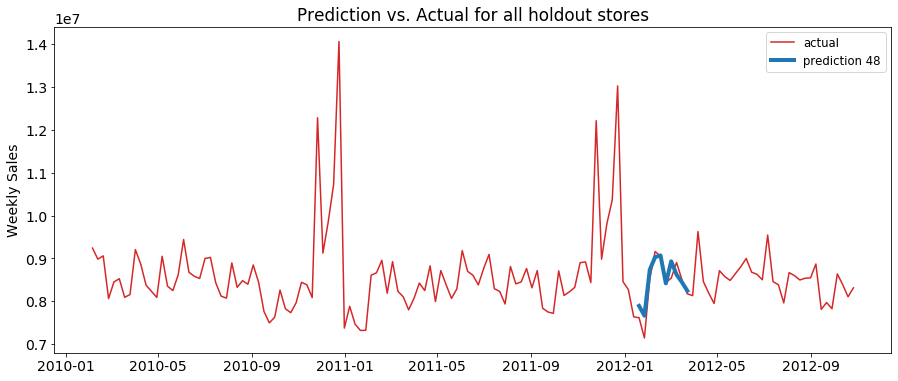

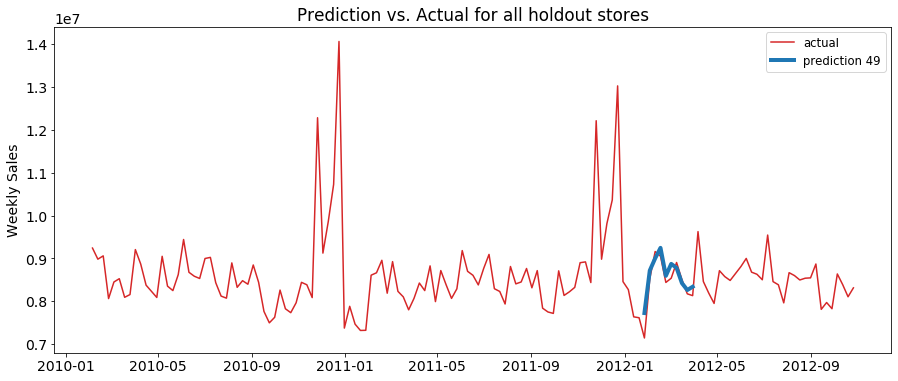

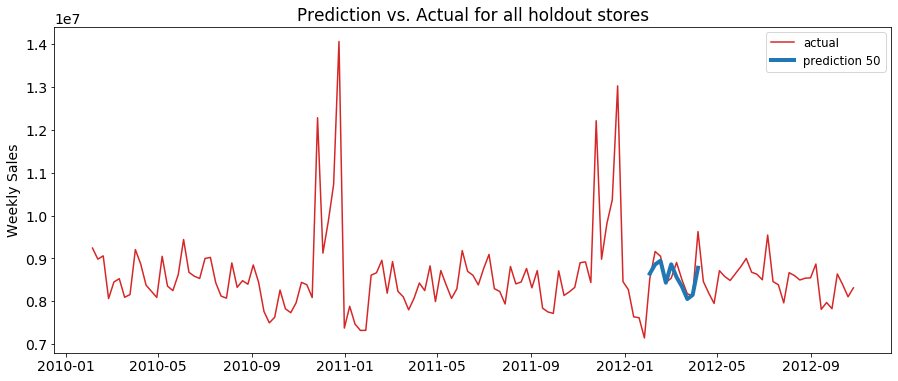

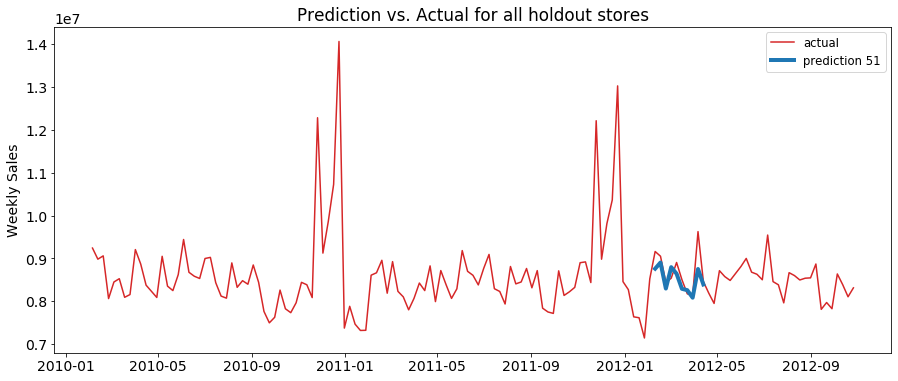

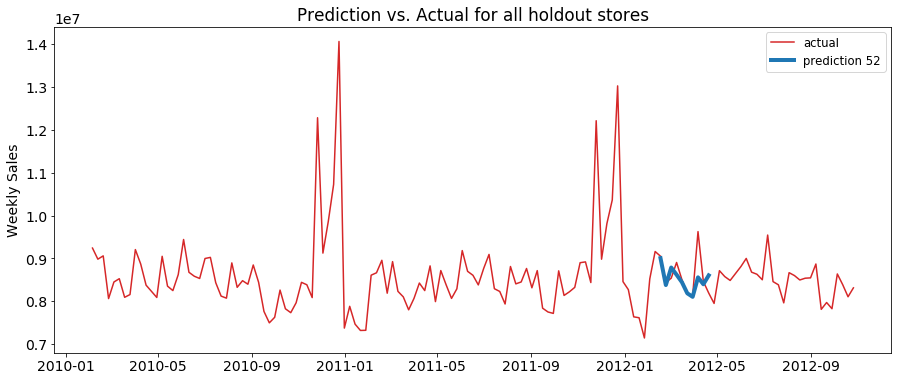

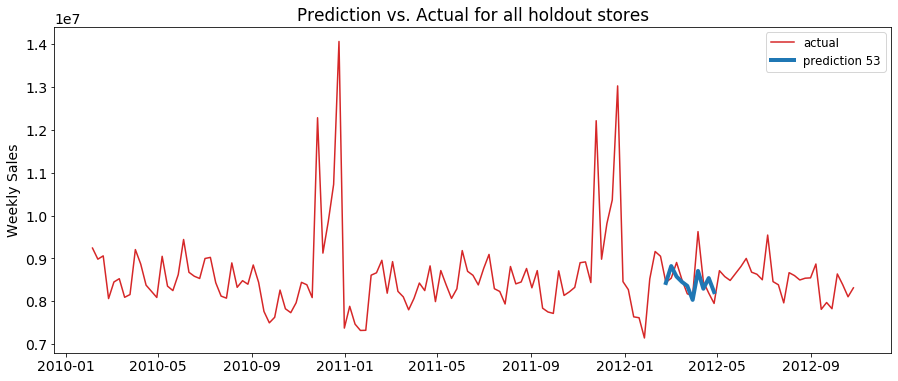

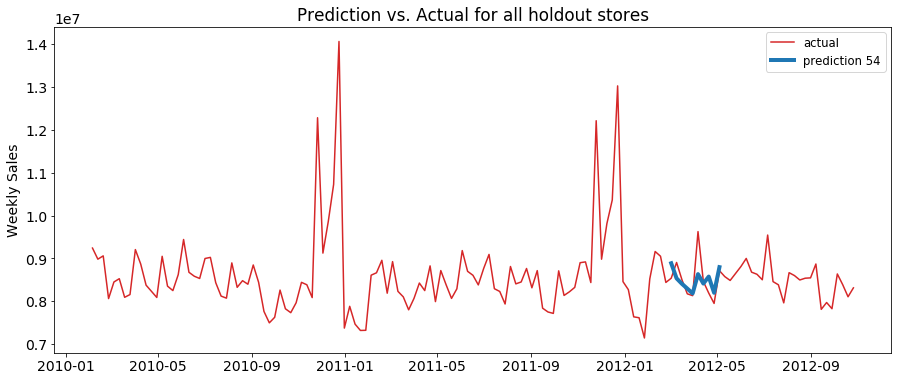

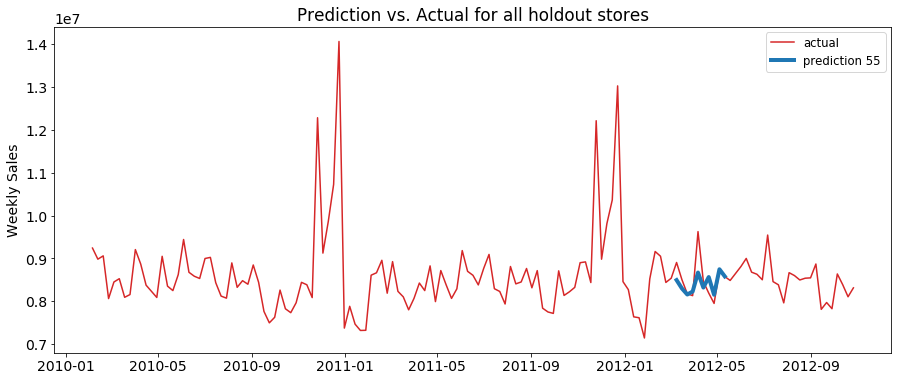

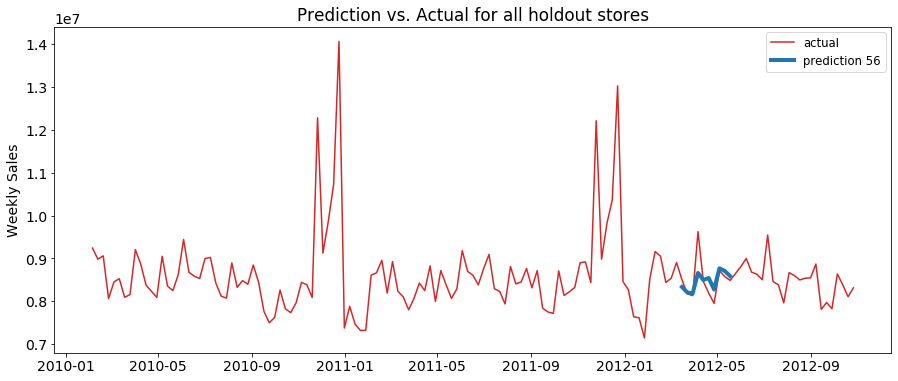

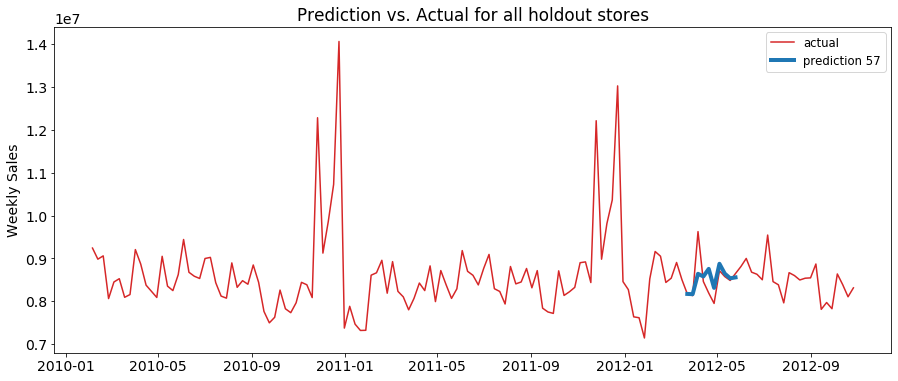

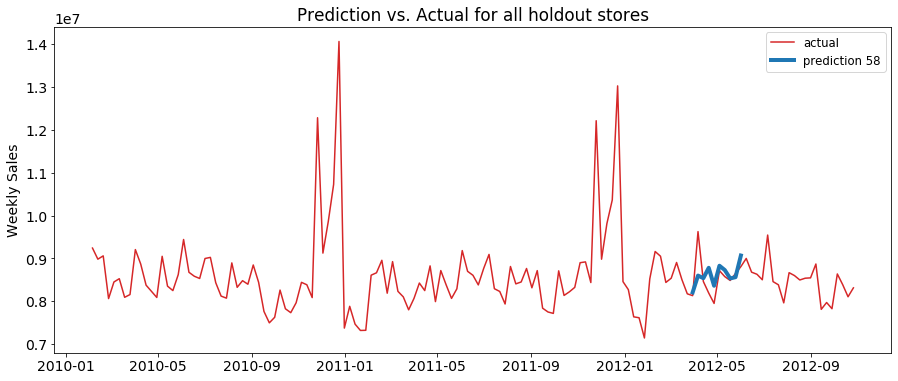

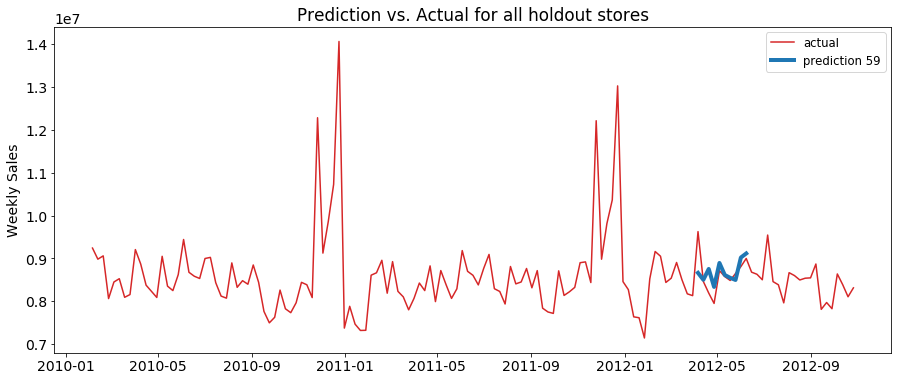

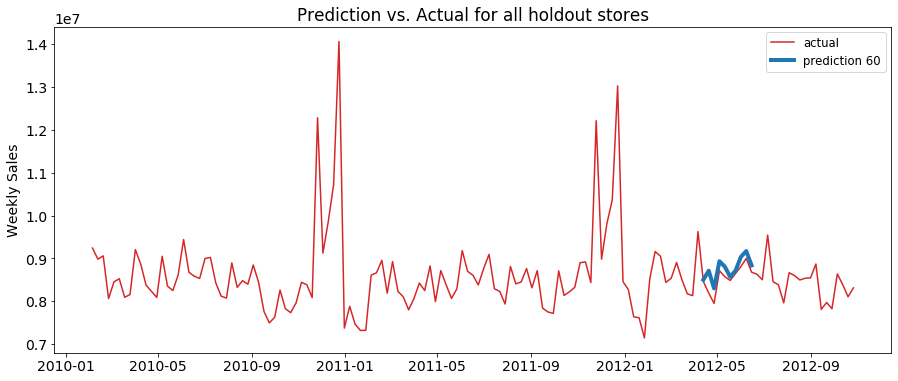

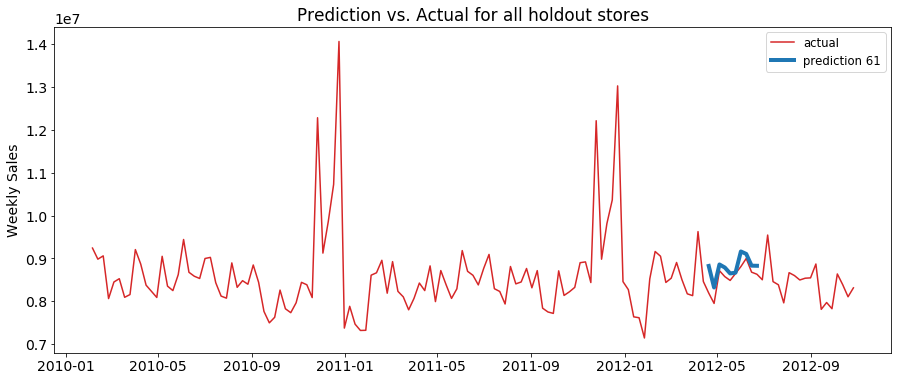

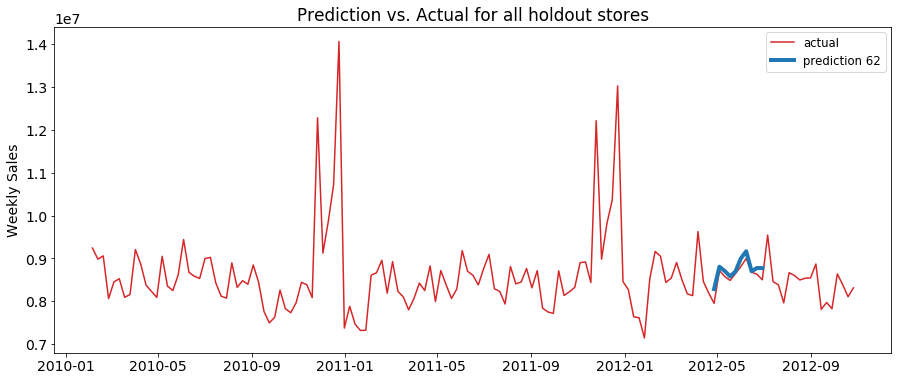

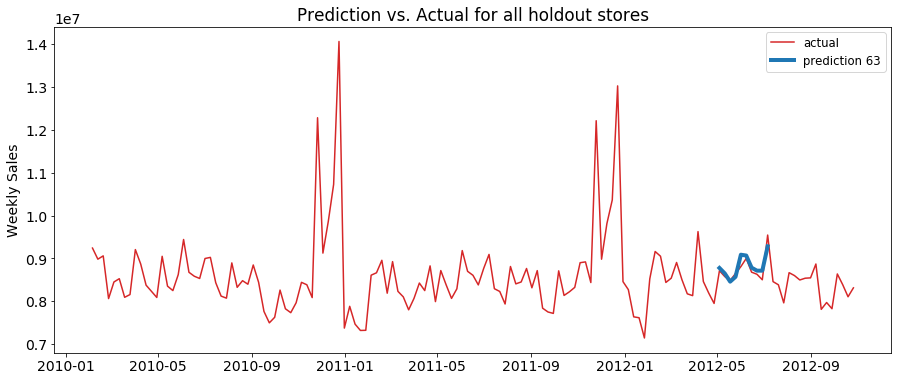

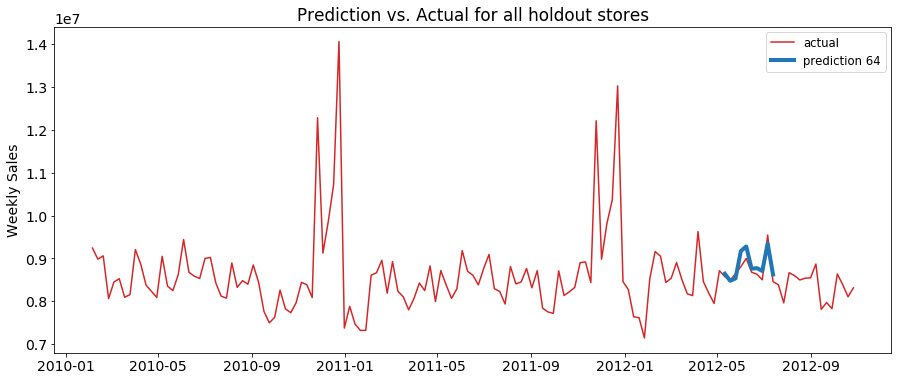

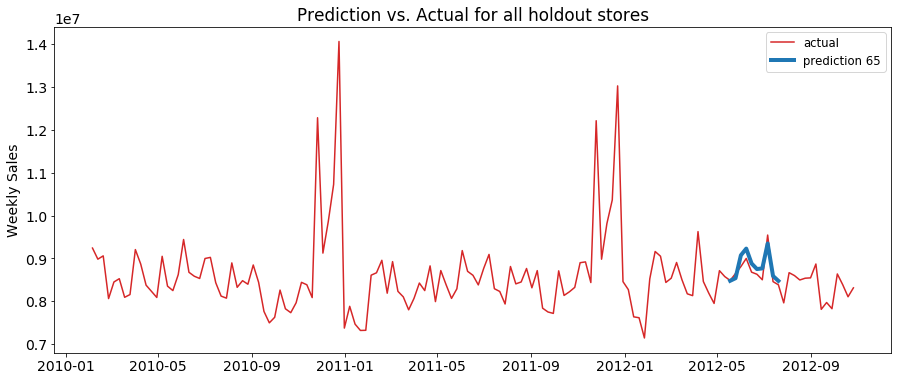

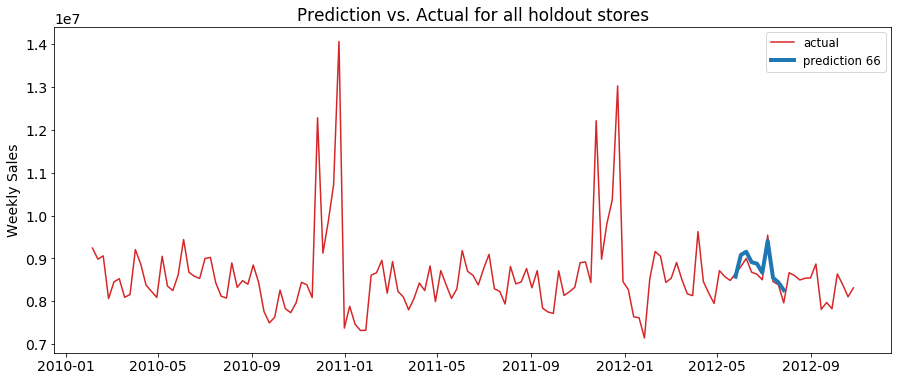

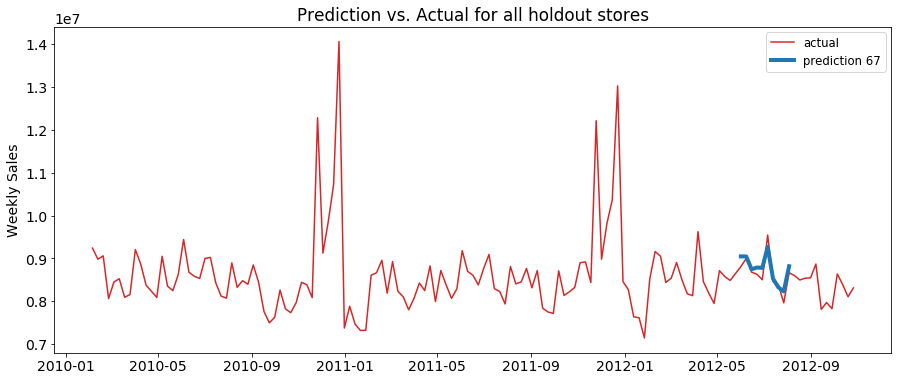

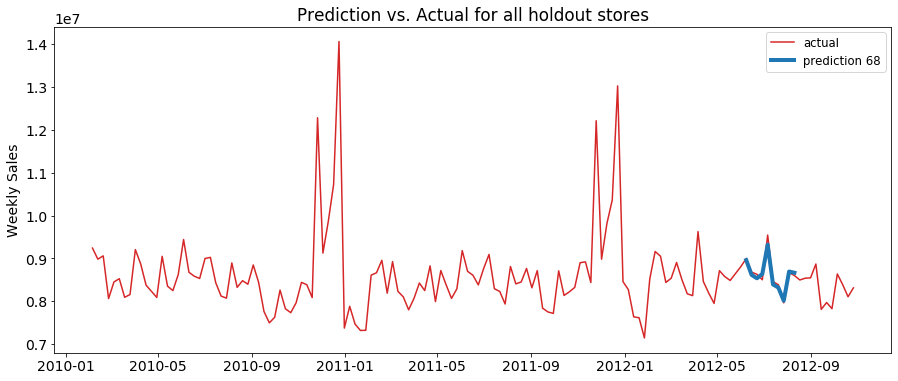

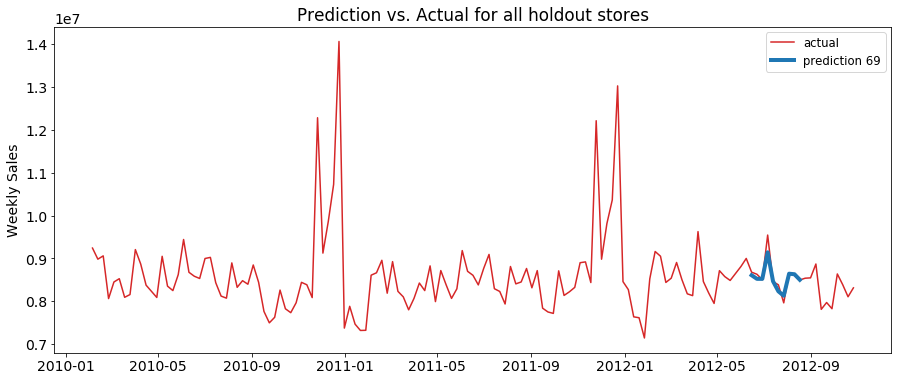

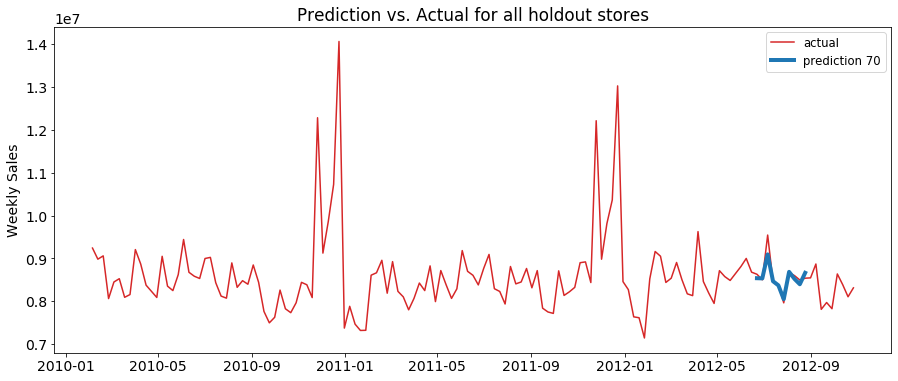

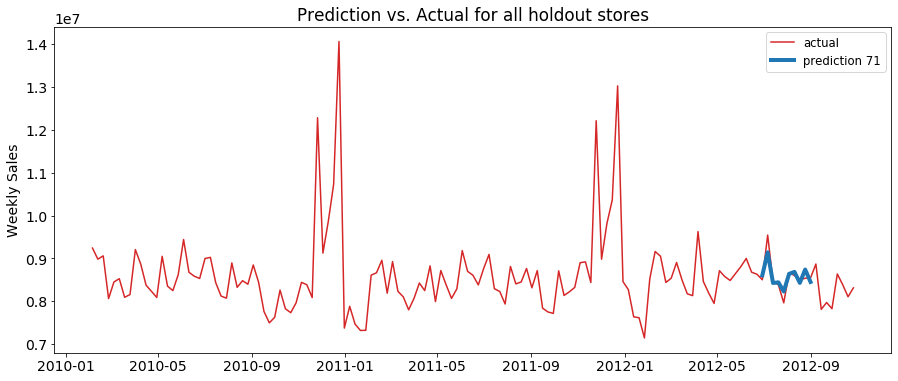

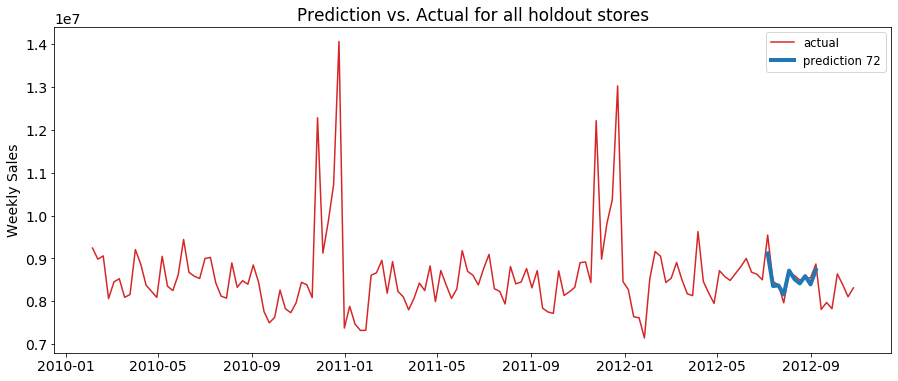

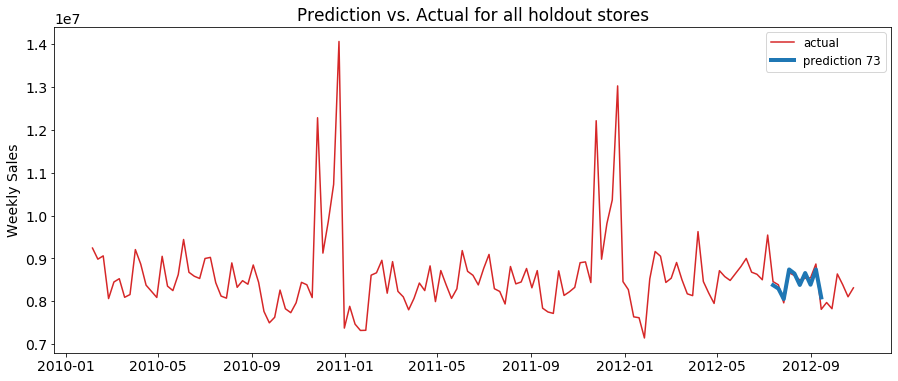

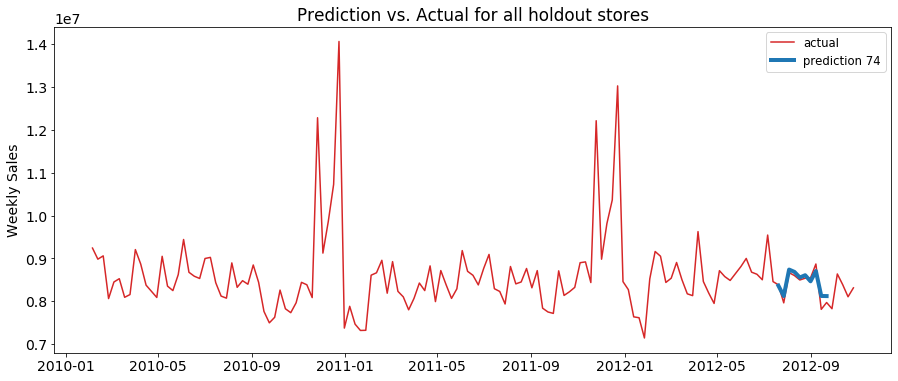

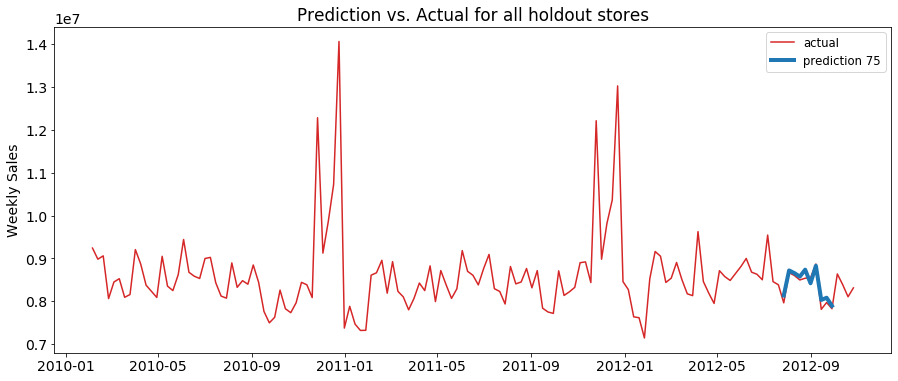

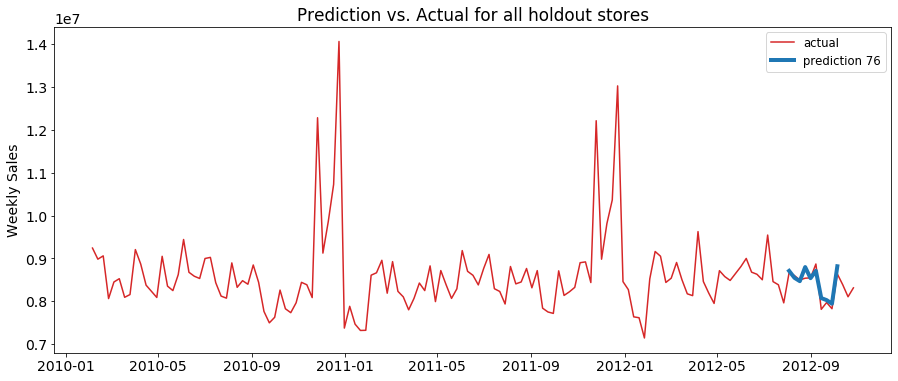

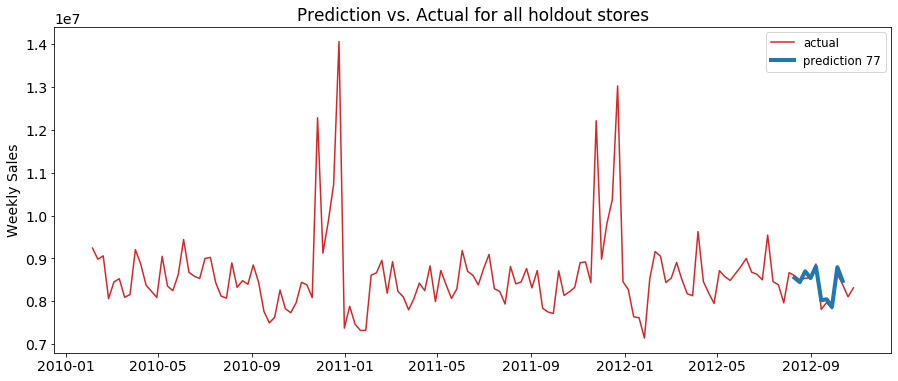

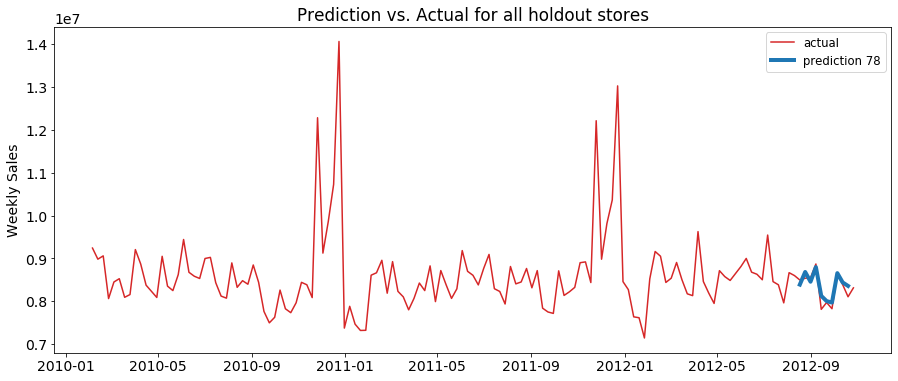

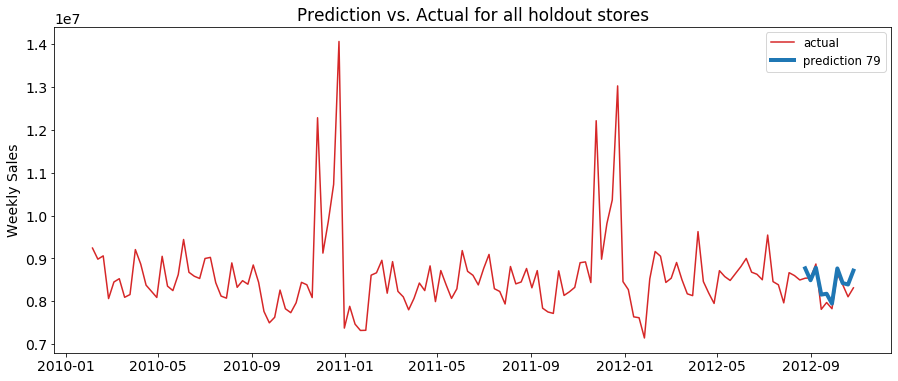

In [192]:
for i in range(80):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(piv_test.sum(axis=1), label='actual', color='tab:red')
    ax.plot(y_test_dates.reshape(-1,10)[i], np.sum(y_pred[i::80], axis=0), label=f'prediction {i}', color='tab:blue', lw=4)

    ax.set_title('Prediction vs. Actual for all holdout stores')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    plt.savefig(f'../images/multivar_gif/rolling_prediction_{i:02}.png');

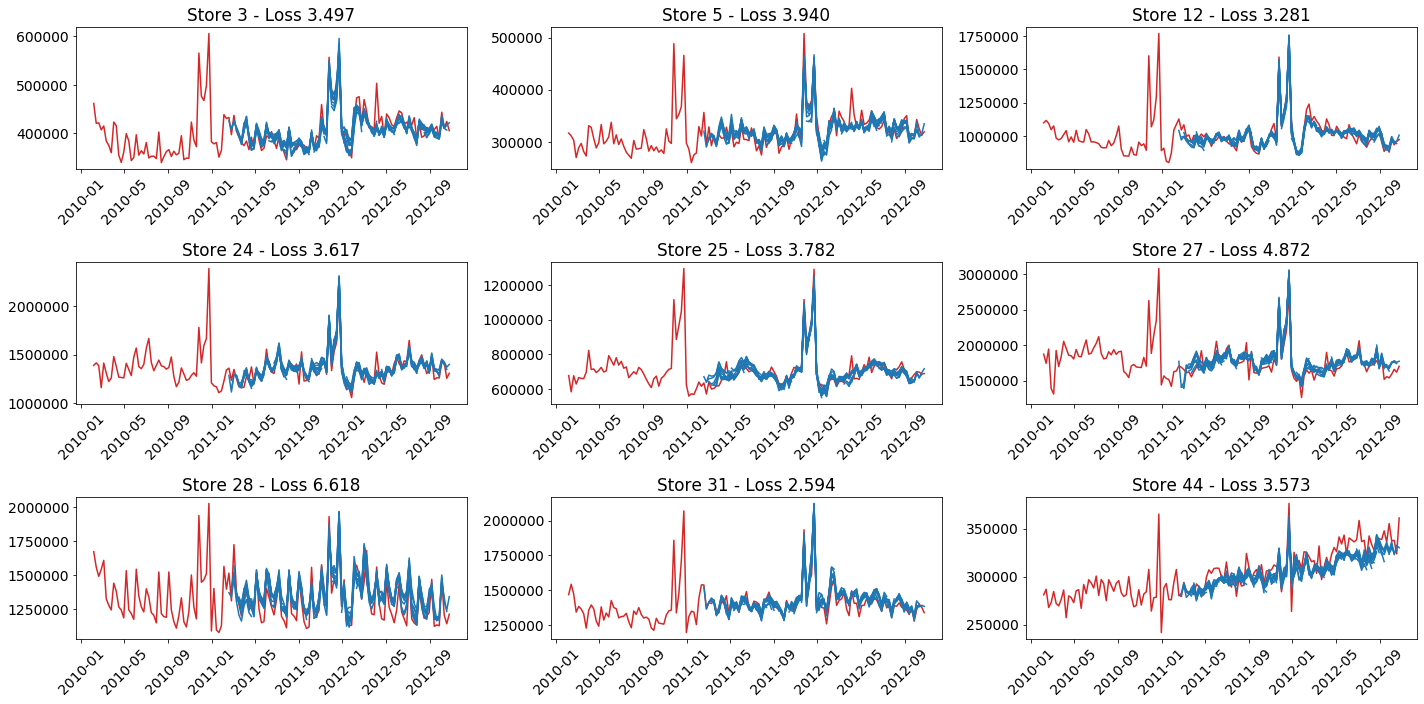

In [392]:
store_arr = piv_test.columns.tolist()

fig, axs = plt.subplots(3,3, figsize=(20,10))

ncols = piv_test.shape[1]
n_pred = len(piv_test) - n_prev - n_future +1
# print(n_pred)
# start = i * n_pred
# stop = start + n_pred
loss=keras.metrics.MAPE(y_test_window.reshape(-1,10),y_pred.reshape(-1,10))
for (i, store), ax in zip(enumerate(store_arr), axs.flatten()):
    ax.plot(piv_test.iloc[:,i], label='actual', color='tab:red')
    store_loss = np.mean(loss[i*n_pred:i*n_pred+n_pred])
    for j in range(0,n_pred):
        idx = i * n_pred +j
        
        ax.plot(y_train_dates.reshape(-1,10)[idx], y_pred.reshape(-1,10)[idx], label=f'prediction {idx}', color='tab:blue')
        ax.set_title(f'Store {store} - Loss {store_loss:.3f}')
        ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()


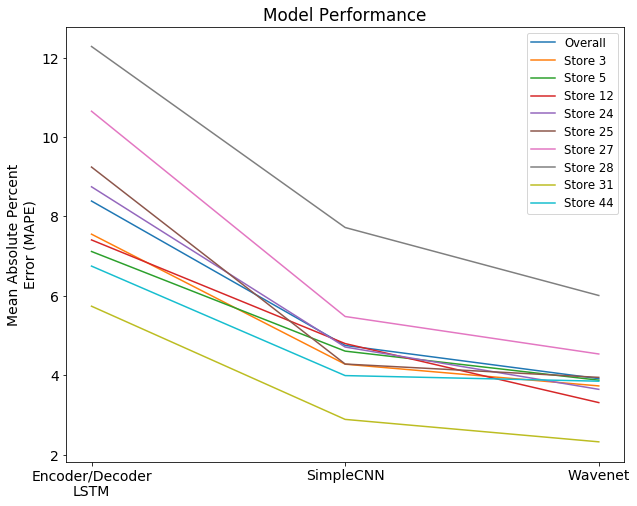

In [377]:
fig, ax = plt.subplots(figsize=(10,8))
models = ['Encoder/Decoder\nLSTM', 'SimpleCNN', 'Wavenet']
overall = [8.389, 4.753, 3.917]
s3 = [7.555, 4.281, 3.734]
s5 = [7.119, 4.610, 3.878]
s12 = [7.410, 4.8, 3.314]
s24 = [8.748, 4.713, 3.648]
s25 = [9.245, 4.285, 3.949]
s27 = [10.651, 5.482, 4.538]
s28 = [12.281, 7.723, 6.011]
s31 = [5.741, 2.891, 2.326]
s44 = [6.751, 3.994, 3.853]

results = [overall, s3, s5, s12, s24, s25, s27, s28, s31, s44]
legend = ['Overall', 'Store 3', 'Store 5', 'Store 12',
          'Store 24', 'Store 25', 'Store 27', 'Store 28',
          'Store 31', 'Store 44']
for elem, label in zip(results, legend):
    ax.plot(range(len(elem)),elem, label=label)
ax.legend()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models)
ax.set_title('Model Performance')
ax.set_ylabel('Mean Absolute Percent\nError (MAPE)');

In [98]:
len(piv_train.columns)

36

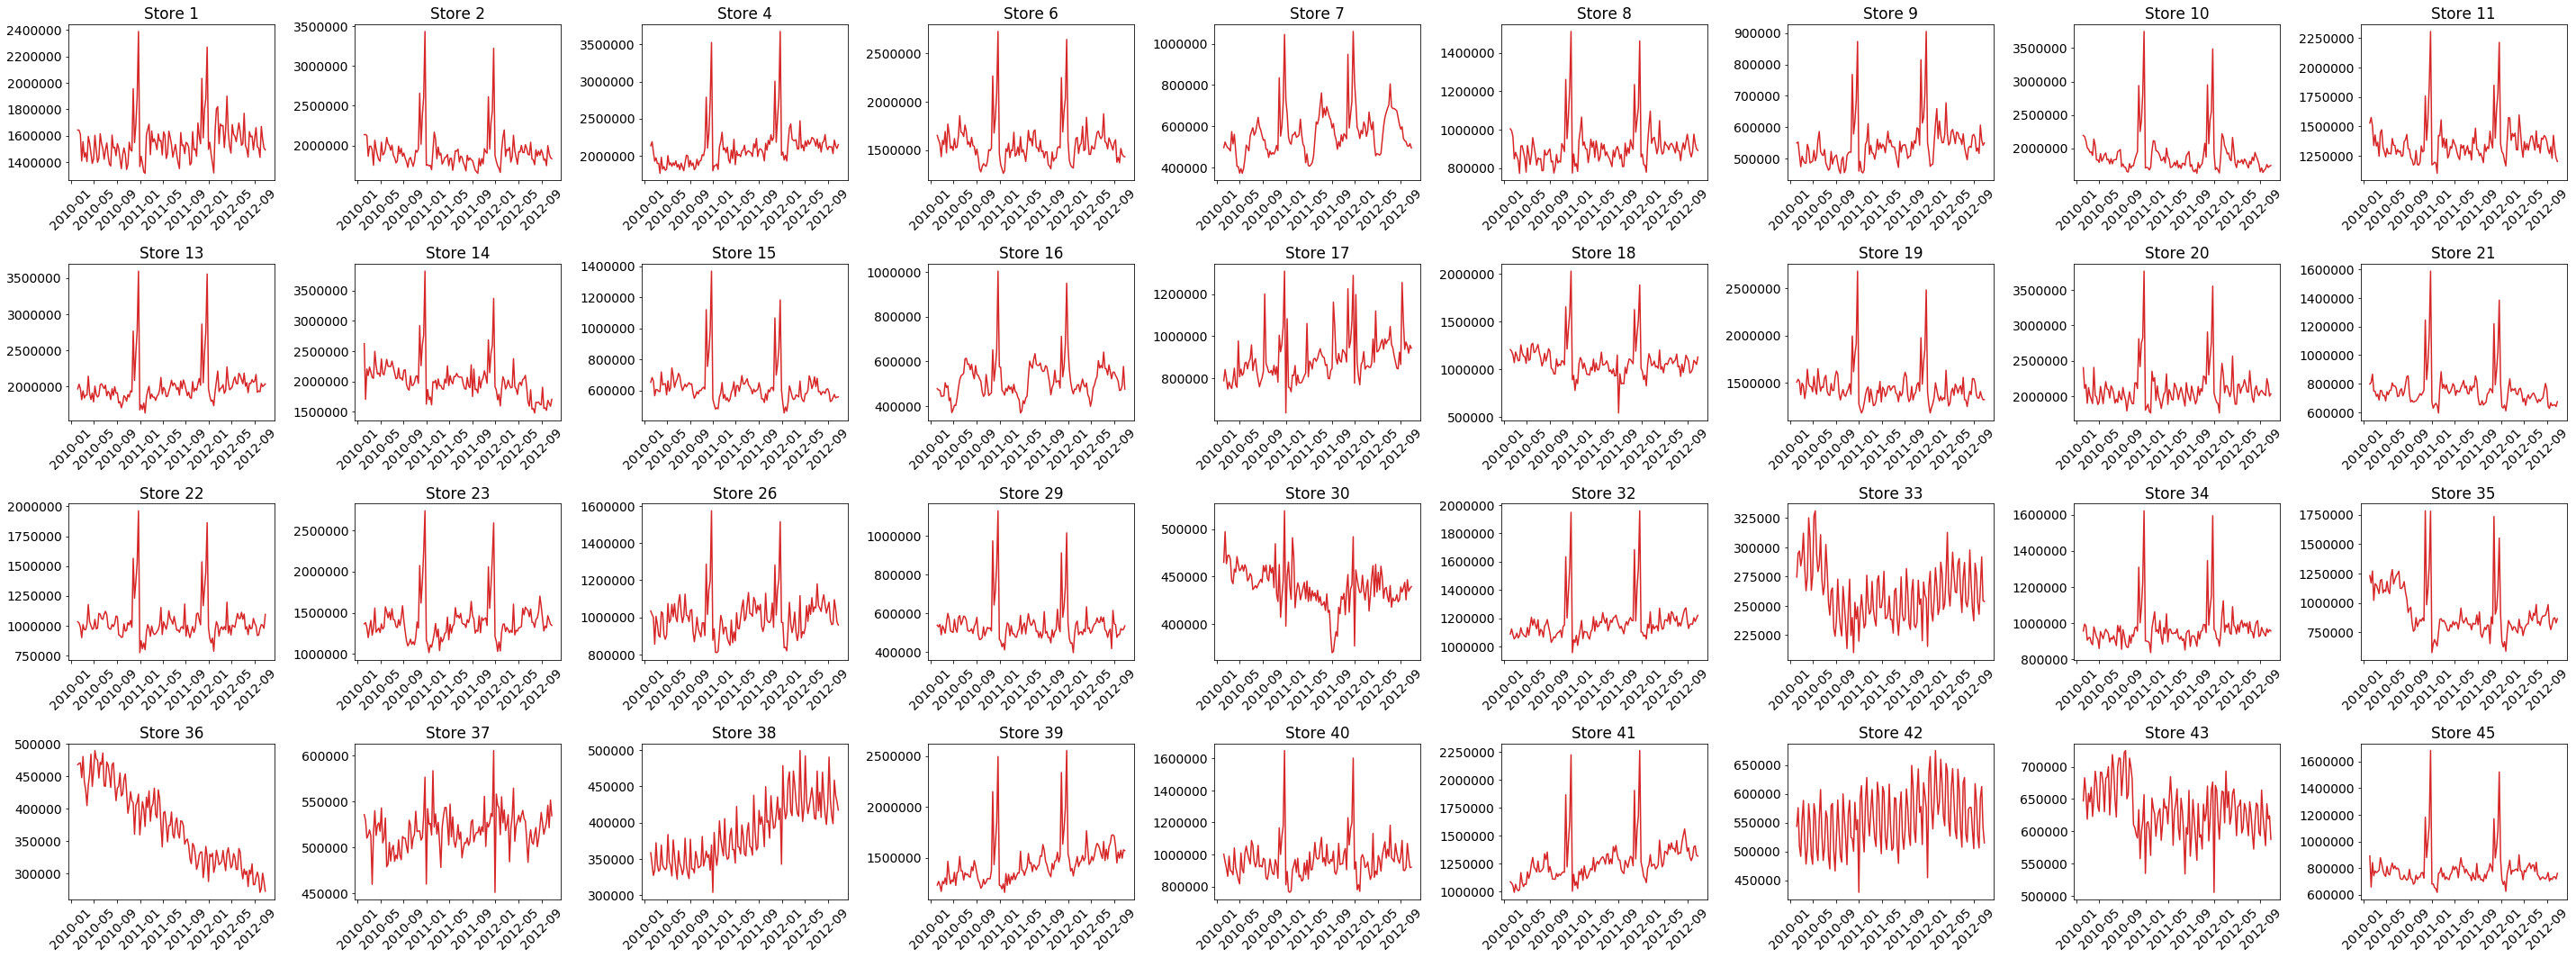

In [149]:
piv_train = X_train[['Store', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_train.index,'Store')
store_arr = piv_train.columns.tolist()

fig, axs = plt.subplots(4,9, figsize=(40,15))

ncols = piv_train.shape[1]
n_pred = len(piv_train) - n_prev - n_future +1

for (i, store), ax in zip(enumerate(store_arr), axs.flatten()):
    ax.plot(piv_train.iloc[:,i], label='actual', color='tab:red')
#     store_loss = np.mean(loss[i*n_pred:i*n_pred+n_pred])
#     for j in range(0,n_pred):
#         idx = i * n_pred +j
        
#         ax.plot(y_train_dates.reshape(-1,10)[idx], y_pred[idx], label=f'prediction {idx}', color='tab:blue')
    ax.set_title(f'Store {store}')
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()

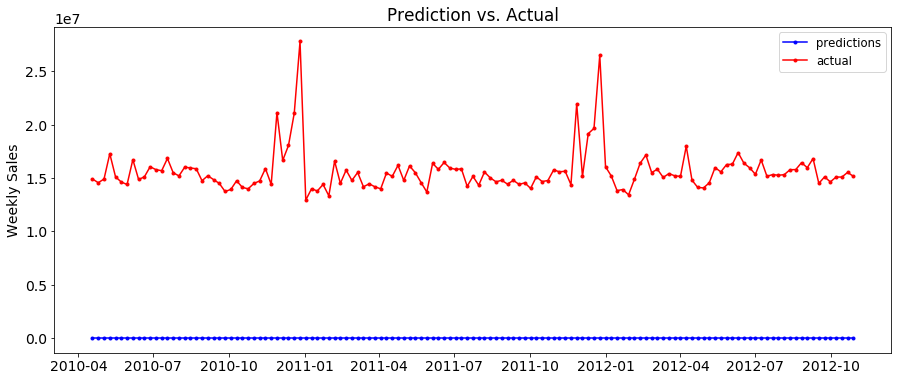

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title('Prediction vs. Actual')
ax.set_ylabel('Weekly Sales');

In [ ]:
y_pred

In [206]:
X_train

Temperature  Fuel_Price       CPI  Unemployment      Size  \
Date                                                                    
2010-02-05    -0.956241   -1.694130  1.003435      0.167116  0.347697   
2010-02-05    -2.720238   -1.220483 -1.050775      0.403089  0.367559   
2010-02-05    -0.308472   -0.838934 -1.182076      1.191929 -0.063524   
2010-02-05    -0.755395   -1.694130  1.089367     -0.288768  1.279197   
2010-02-05    -2.168854   -1.676587  0.442830     -0.492001 -1.212729   
...                 ...         ...       ...           ...       ...   
2012-10-26    -0.134011    1.255199 -0.864887      0.812644 -0.608557   
2012-10-26    -0.706395    1.255199 -0.864887     -0.430846  0.367559   
2012-10-26    -0.512010    1.255199 -0.864887     -2.279709 -0.262129   
2012-10-26    -0.114088    0.371497 -1.059419      0.619912  0.460420   
2012-10-26    -0.065626    1.178451  0.518401      0.513663 -0.200984   

            Type_x0_A  Type_x0_B  Type_x0_C  Month_x0_1  Month_x0_2  \
Date                                                                  
2010-02-05        1.0        0.0        0.0         0.0         1.0   
2010-02-05        1.0        0.0        0.0         0.0         1.0   
2010-02-05        0.0        1.0        0.0         0.0         1.0   
2010-02-05        1.0        0.0        0.0         0.0         1.0   
2010-02-05        0.0        1.0        0.0         0.0         1.0   
...               ...        ...        ...         ...         ...   
2012-10-26        0.0        1.0        0.0         0.0         0.0   
2012-10-26        1.0        0.0        0.0         0.0         0.0   
2012-10-26        0.0        1.0        0.0         0.0         0.0   
2012-10-26        1.0        0.0        0.0         0.0         0.0   
2012-10-26        0.0        1.0        0.0         0.0         0.0   

            Month_x0_3  Month_x0_4  Month_x0_5  Month_x0_6  Month_x0_7  \
Date                                                                     
2010-02-05         0.0         0.0         0.0         0.0         0.0   
2010-02-05         0.0         0.0         0.0         0.0         0.0   
2010-02-05         0.0         0.0         0.0         0.0         0.0   
2010-02-05         0.0         0.0         0.0         0.0         0.0   
2010-02-05         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2012-10-26         0.0         0.0         0.0         0.0         0.0   
2012-10-26         0.0         0.0         0.0         0.0         0.0   
2012-10-26         0.0         0.0         0.0         0.0         0.0   
2012-10-26         0.0         0.0         0.0         0.0         0.0   
2012-10-26         0.0         0.0         0.0         0.0         0.0   

            Month_x0_8  Month_x0_9  Month_x0_10  Month_x0_11  Month_x0_12  \
Date                                                                        
2010-02-05         0.0         0.0          0.0          0.0          0.0   
2010-02-05         0.0         0.0          0.0          0.0          0.0   
2010-02-05         0.0         0.0          0.0          0.0          0.0   
2010-02-05         0.0         0.0          0.0          0.0          0.0   
2010-02-05         0.0         0.0          0.0          0.0          0.0   
...                ...         ...          ...          ...          ...   
2012-10-26         0.0         0.0          1.0          0.0          0.0   
2012-10-26         0.0         0.0          1.0          0.0          0.0   
2012-10-26         0.0         0.0          1.0          0.0          0.0   
2012-10-26         0.0         0.0          1.0          0.0          0.0   
2012-10-26         0.0         0.0          1.0          0.0          0.0   

            Store  IsHoliday  Weekly_Sales  
Date                                        
2010-02-05      1      False    1643690.90  
2010-02-05     26      False    103411

In [221]:
mask = X_test['Store'] == 3
s1 = X_test[mask].copy()
s1

Temperature  Fuel_Price       CPI  Unemployment      Size  \
Date                                                                    
2010-02-05    -0.773164   -1.694130  1.089367     -0.288768 -1.541086   
2010-02-12    -0.653626   -1.746757  1.093237     -0.288768 -1.541086   
2010-02-19    -0.699933   -1.821313  1.094402     -0.288768 -1.541086   
2010-02-26    -0.431780   -1.718251  1.095115     -0.288768 -1.541086   
2010-03-05    -0.378472   -1.577911  1.095828     -0.288768 -1.541086   
...                 ...         ...       ...           ...       ...   
2012-09-28     0.936449    0.704804  1.401576     -0.927500 -1.541086   
2012-10-05     0.682296    0.597356  1.406816     -1.112819 -1.541086   
2012-10-12     0.551450    0.562271  1.412055     -1.112819 -1.541086   
2012-10-19     0.719988    0.546922  1.413213     -1.112819 -1.541086   
2012-10-26     0.785680    0.353954  1.413691     -1.112819 -1.541086   

            Type_x0_A  Type_x0_B  Type_x0_C  Month_x0_1  Month_x0_2  \
Date                                                                  
2010-02-05        0.0        1.0        0.0         0.0         1.0   
2010-02-12        0.0        1.0        0.0         0.0         1.0   
2010-02-19        0.0        1.0        0.0         0.0         1.0   
2010-02-26        0.0        1.0        0.0         0.0         1.0   
2010-03-05        0.0        1.0        0.0         0.0         0.0   
...               ...        ...        ...         ...         ...   
2012-09-28        0.0        1.0        0.0         0.0         0.0   
2012-10-05        0.0        1.0        0.0         0.0         0.0   
2012-10-12        0.0        1.0        0.0         0.0         0.0   
2012-10-19        0.0        1.0        0.0         0.0         0.0   
2012-10-26        0.0        1.0        0.0         0.0         0.0   

            Month_x0_3  Month_x0_4  Month_x0_5  Month_x0_6  Month_x0_7  \
Date                                                                     
2010-02-05         0.0         0.0         0.0         0.0         0.0   
2010-02-12         0.0         0.0         0.0         0.0         0.0   
2010-02-19         0.0         0.0         0.0         0.0         0.0   
2010-02-26         0.0         0.0         0.0         0.0         0.0   
2010-03-05         1.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
2012-09-28         0.0         0.0         0.0         0.0         0.0   
2012-10-05         0.0         0.0         0.0         0.0         0.0   
2012-10-12         0.0         0.0         0.0         0.0         0.0   
2012-10-19         0.0         0.0         0.0         0.0         0.0   
2012-10-26         0.0         0.0         0.0         0.0         0.0   

            Month_x0_8  Month_x0_9  Month_x0_10  Month_x0_11  Month_x0_12  \
Date                                                                        
2010-02-05         0.0         0.0          0.0          0.0          0.0   
2010-02-12         0.0         0.0          0.0          0.0          0.0   
2010-02-19         0.0         0.0          0.0          0.0          0.0   
2010-02-26         0.0         0.0          0.0          0.0          0.0   
2010-03-05         0.0         0.0          0.0          0.0          0.0   
...                ...         ...          ...          ...          ...   
2012-09-28         0.0         1.0          0.0          0.0          0.0   
2012-10-05         0.0         0.0          1.0          0.0          0.0   
2012-10-12         0.0         0.0          1.0          0.0          0.0   
2012-10-19         0.0         0.0          1.0          0.0          0.0   
2012-10-26         0.0         0.0          1.0          0.0          0.0   

            Store  IsHoliday  Weekly_Sales  
Date                                        
2010-02-05      3      False     461622.22  
2010-02-12      3       True     42072

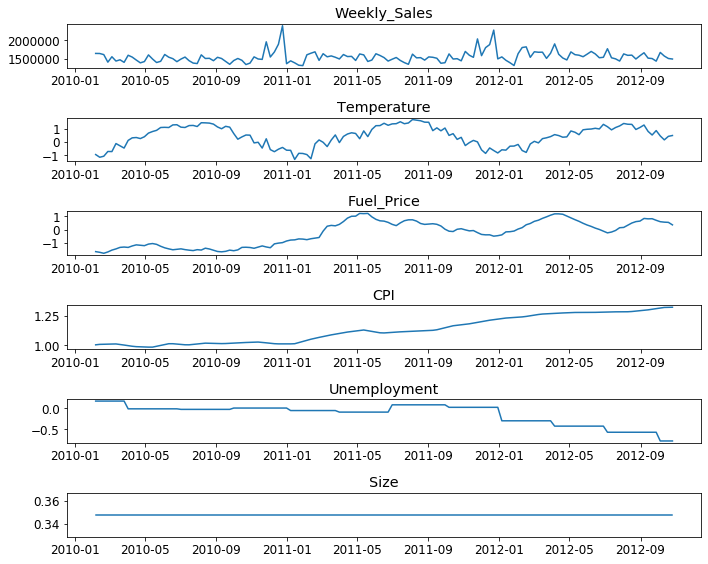

In [248]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

fig, axs = plt.subplots(6, 1, figsize=(10,8))
cont_feats = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Size']
for col, ax in zip(cont_feats, axs.flatten()):
    for store in [1]:
        ax.plot(X_train[X_train['Store'] == store][col], label=f'Store {store}')
#     ax.legend()
    ax.set_title(col)

plt.tight_layout();

In [393]:
piv_test = X_test[['Store', 'Weekly_Sales']].pivot_table('Weekly_Sales', X_test.index,'Store')


In [394]:
dates = X_test.index.unique()[-54:]
mask = X_test.index.isin(dates)
cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'Month_x0_11', 'Month_x0_12', 'IsHoliday','Store']
test_df = X_test[cols][mask].sort_values(['Store','Date']).drop(columns='Store')

x = np.zeros((9, 54, 9))

for i in range(9):
    start = i * 54
    stop = start + 54
    x[i, :, :] = test_df.iloc[start:stop,:]


In [395]:
y_future = model.predict(x)

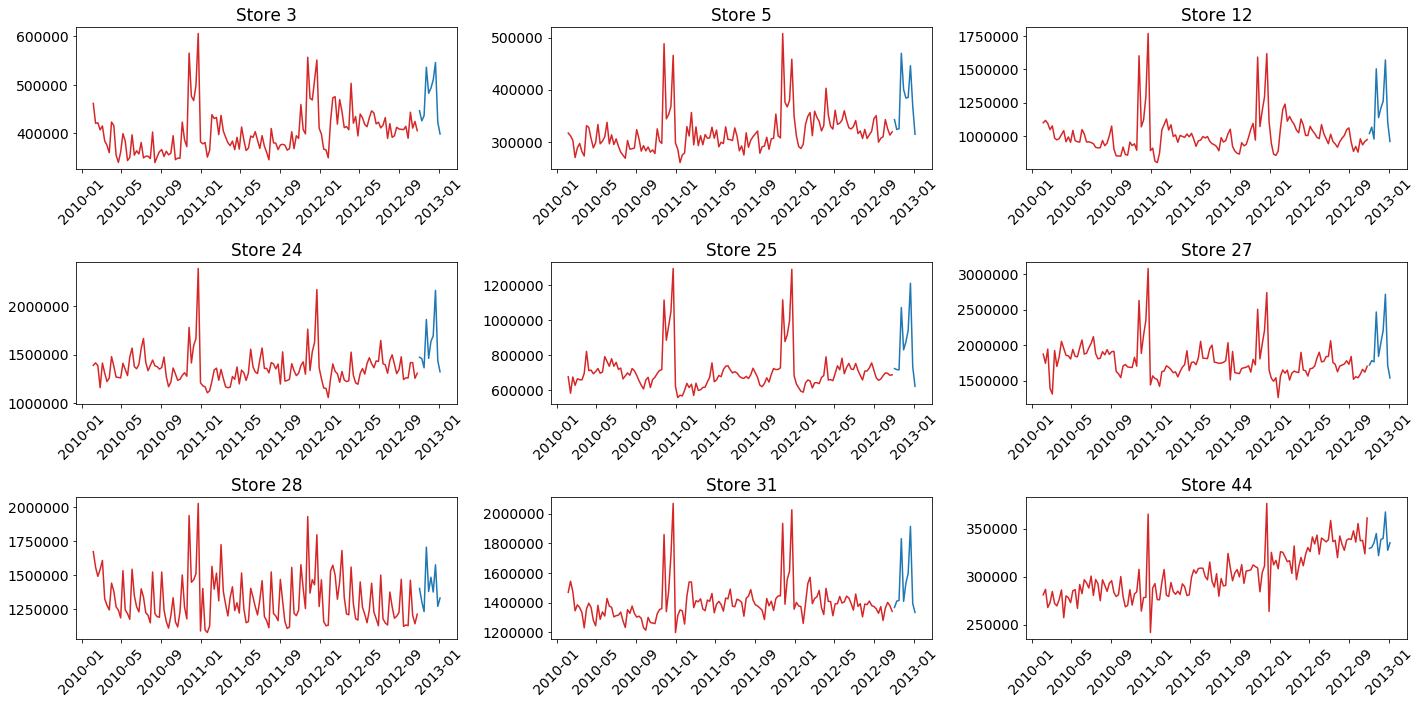

In [396]:
import datetime

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

u = X_test.index.unique()[-10:]
d = datetime.timedelta(days=70)
t = u + d

store_arr = piv_test.columns.tolist()

fig, axs = plt.subplots(3,3, figsize=(20,10))
# ncols = piv_test.shape[1]
# n_pred = len(piv_test) - n_prev - n_future +1

for (i, store), ax in zip(enumerate(store_arr), axs.flatten()):
    ax.plot(piv_test.iloc[:,i], label='actual', color='tab:red')
    ax.plot(t, y_future[i], label=f'prediction {idx}', color='tab:blue')
    ax.set_title(f'Store {store}')
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()

In [311]:
print(u,"\n",t)

DatetimeIndex(['2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', freq=None) 
 DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04'],
              dtype='datetime64[ns]', name='Date', freq=None)


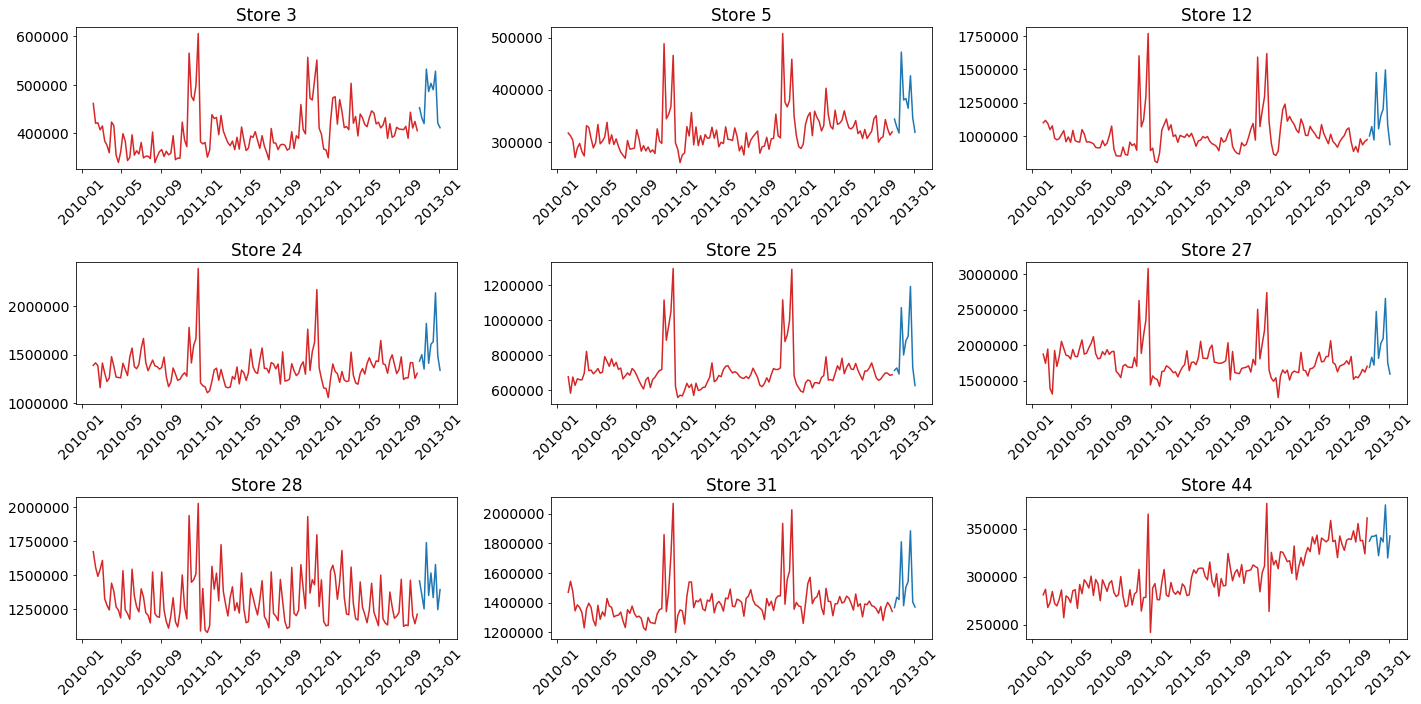

In [343]:
import datetime

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

u = X_test.index.unique()[-10:]
d = datetime.timedelta(days=70)
t = u + d

store_arr = piv_test.columns.tolist()

fig, axs = plt.subplots(3,3, figsize=(20,10))
# ncols = piv_test.shape[1]
# n_pred = len(piv_test) - n_prev - n_future +1

for (i, store), ax in zip(enumerate(store_arr), axs.flatten()):
    ax.plot(piv_test.iloc[:,i], label='actual', color='tab:red')
    ax.plot(t, y_future[i], label=f'prediction {idx}', color='tab:blue')
    ax.set_title(f'Store {store}')
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()